<a href="https://colab.research.google.com/github/chatwipa-sur/SRCC_detection/blob/main/Student_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trian Student model
- Train CenterNet model with original ground truth label and pseudo-label from teacher model

In [1]:
# Standard library for file and directory operations
import os
from datetime import datetime
import sys

# Library for parsing XML files (used for annotations)
import xml.etree.ElementTree as ET

# Core PyTorch library for tensor operations
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import random_split
import torch.nn as nn
import torchvision
from torchvision.ops import nms, box_iou
from torchvision.models import ResNet50_Weights, ResNet34_Weights, ResNet18_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Library for numerical computations
import numpy as np
from scipy.ndimage import maximum_filter
import pandas as pd
import time

# Library for data visualization
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Mount the drive with google colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Create Dataset

In [3]:
# Make heatmaps using the utility functions from the centernet repo
# Draw a Gaussian centered at a point on a heatmap
def draw_msra_gaussian(heatmap, center, sigma=7):
  # Total size (radius) of the Gaussian region
  tmp_size = sigma * 6

  # Round the x and y center to nearest int
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)

  # Get heatmap dimensions
  w, h = heatmap.shape[0], heatmap.shape[1]

  # Upper-left and bottom-right corners of the Gaussian patch
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]

  # If Gaussian patch is completely outside the heatmap, return
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap

  # Create a 2D Gaussian
  size = 2 * tmp_size + 1 # Size of the Gaussian patch
  x = np.arange(0, size, 1, np.float32) # x coordinates
  y = x[:, np.newaxis] # y coordinates
  x0 = y0 = size // 2 # Center of the Gaussian
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)) # 2D Gaussian formula

  # Compute valid bounds for placing the Gaussian patch on the heatmap
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)

  # Place the Gaussian on the heatmap using max to retain highest intensity
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])

  return heatmap

# Draw a dense regression value map around a center point
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  # Size of the square region
  diameter = 2 * radius + 1
  # Create Gaussian mask
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

  # Convert value to float32 and reshape to [dim, 1, 1]
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]

  # Create a repeated value map of shape [dim, H, W]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value

  # If it's an offset, adjust the values using distance from center
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)

  # Center coordinates
  x, y = int(center[0]), int(center[1])

  # Heatmap dimensions
  height, width = heatmap.shape[0:2]

  # Compute boundaries (clipping at image edges)
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  # Crop regions from heatmap, regmap, Gaussian, and value maps
  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]

  # Only update if region is valid (non-zero size)
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug

    # Create a mask where Gaussian is stronger than existing heatmap
    idx = (masked_gaussian >= masked_heatmap).reshape(1, masked_gaussian.shape[0],
                                                      masked_gaussian.shape[1])

    # Update regmap only where mask is True (using Gaussian gate)
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg

  # Write updated region back to original regmap
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap

  return regmap

def gaussian2D(shape, sigma=1):
    # Get center and coordinate grid
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    # Apply 2D Gaussian function
    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))

    # Remove near-zero values for stability
    h[h < np.finfo(h.dtype).eps * h.max()] = 0

    return h

def make_hm_regr(target, input_size=512, MODEL_SCALE=4):

    IN_SCALE = 1
    # make output heatmap for single class
    hm = np.zeros([input_size//MODEL_SCALE, input_size//MODEL_SCALE], dtype=np.float32)
    # make regr heatmap
    regr = np.zeros([2, input_size//MODEL_SCALE, input_size//MODEL_SCALE], dtype=np.float32)

    if target.empty:
        return hm, regr

    center = np.array([target["x"] + target["w"]//2, target["y"] + target["h"]//2,
                       target["w"], target["h"]]).T

    # make a center point
    # try gaussian points.
    for c in center:
        hm = draw_msra_gaussian(hm, [int(c[0])//MODEL_SCALE//IN_SCALE,
                                     int(c[1])//MODEL_SCALE//IN_SCALE],
                                sigma=np.clip(c[2]*c[3]//2000, 5, 10))

    # convert targets to its center.
    regrs = center[:, 2:]/input_size/IN_SCALE

    # plot regr values to mask
    for r, c in zip(regrs, center):
        for i in range(-2, 3):
            for j in range(-2, 3):
                try:
                    regr[:, int(c[0])//MODEL_SCALE//IN_SCALE+i,
                         int(c[1])//MODEL_SCALE//IN_SCALE+j] = r
                except:
                    pass
    regr[0] = regr[0].T; regr[1] = regr[1].T;

    return hm, regr

def pred2box(hm, regr, thresh=0.99, MODEL_SCALE=4, input_size=512):
    pred = hm > thresh
    pred_center = np.where(pred)
    pred_r = regr[:, pred].T  # Shape: [N, 2] for w, h
    boxes = []
    scores = hm[pred]

    for i, b in enumerate(pred_r):
        cx = pred_center[1][i] * MODEL_SCALE
        cy = pred_center[0][i] * MODEL_SCALE

        w = b[0] * input_size
        h = b[1] * input_size

        x1 = cx - w /2
        y1 = cy - h /2

        arr = np.clip([x1, y1, w, h], 0, input_size)
        boxes.append(arr)

    return np.asarray(boxes), scores


# Assuming `image` is a torch.Tensor of shape (3, H, W)
def unnormalize_tensor(image):
  mean = [0.485, 0.456, 0.406]
  std  = [0.229, 0.224, 0.225]
  for t, m, s in zip(image, mean, std):
    t.mul_(s).add_(m)
  return image

In [4]:
class SignetRingCellPatchCenterNetDataset(Dataset):
  def __init__(self, image_dir, annotation_dir, patch_size=512, transform=None):
    # Initialize parameters
    self.patch_size = patch_size
    self.stride = patch_size//2  # 50% overlap for 512x512 patches
    self.transform = transform
    self.image_information = []

    # Loop over positive and negative folders
    for class_type in ['positive', 'negative']:
    # for class_type in ['positive']:
      full_image_dir = os.path.join(image_dir, class_type)
      full_anno_dir = os.path.join(annotation_dir, class_type)

      # Iterate over image files in the folder
      for fname in os.listdir(full_image_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
          # Collect image path
          image_path = os.path.join(full_image_dir, fname)

          # Collect annotation path
          if class_type == "positive":
            anno_filename = fname.replace('.png', '.xml').replace('.jpg', '.xml').replace('.jpeg', '.xml')
            anno_path = os.path.join(full_anno_dir, anno_filename)
          else:
            anno_path = None  # no annotation for negatives

          # Get the size of image
          image = cv2.imread(image_path)
          height, width = image.shape[:2]

          # Generate sliding window patches
          for top in range(0, height - self.patch_size + 1, self.stride):
            for left in range(0, width - self.patch_size + 1, self.stride):
              self.image_information.append({
                  'image_path': image_path,
                  'annotation_path': anno_path,
                  'crop_box': (left, top, left + self.patch_size, top + self.patch_size),
                  'flag': 1 if class_type == 'positive' else 0
              })

  def __len__(self):
    return len(self.image_information) # Total number of patches

  def __getitem__(self, idx):
    # Get image for this index
    image_info = self.image_information[idx]
    image = cv2.imread(image_info['image_path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crop patch using numpy slicing: [top:bottom, left:right]
    left, top, right, bottom = image_info['crop_box']
    image_patch = image[top:bottom, left:right]

    # Get type of image
    flag = image_info['flag']

    # Load and process annotations
    boxes_list = []
    category_ids = []
    if image_info['annotation_path'] is not None:
        tree = ET.parse(image_info['annotation_path'])
        root = tree.getroot()

        crop_xmin, crop_ymin, crop_xmax, crop_ymax = image_info['crop_box']
        for obj in root.findall('object'):
            name = obj.find('name').text
            if name == 'ring_cell_cancer':
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                if (xmin >= crop_xmin and xmax <= crop_xmax) and (ymin >= crop_ymin and ymax <= crop_ymax):
                    new_xmin = xmin - crop_xmin
                    new_ymin = ymin - crop_ymin
                    new_xmax = xmax - crop_xmin
                    new_ymax = ymax - crop_ymin
                    boxes_list.append((new_xmin, new_ymin,
                                       new_xmax - new_xmin,
                                       new_ymax - new_ymin))
                    category_ids.append(1)  # ring_cell_cancer

    # Apply transform (if any)
    if self.transform and len(boxes_list) > 0:
        transformed = self.transform(
            image=image_patch,
            bboxes=boxes_list,
            category_ids=category_ids
        )
        image_patch = transformed['image']
        boxes_list = transformed['bboxes']
    elif self.transform:
        transformed = self.transform(image=image_patch, bboxes=[], category_ids=[])
        image_patch = transformed['image']

    # Generate heatmap + regression map
    if len(boxes_list) == 0:
        hm = np.zeros([self.patch_size // 4, self.patch_size // 4], dtype=np.float32)
        regr = np.zeros([2, self.patch_size // 4, self.patch_size // 4], dtype=np.float32)
    else:
        target = pd.DataFrame(boxes_list, columns=['x', 'y', 'w', 'h'])
        hm, regr = make_hm_regr(target)

    return image_patch, hm, regr, boxes_list, flag

### 1.1 Transform function

In [5]:
# Transform function
train_transform = A.Compose([
    # Spatial augmentations
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(translate_percent=(-0.05, 0.05), scale=(0.9, 1.1), rotate=(-15, 15), p=0.5),

    # Normalization & Tensor conversion
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),  # converts image and bounding boxes to torch.Tensor
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

# Transform function
val_test_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

/usr/local/lib/python3.11/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


### 1.2 Visualize dataset
- Check `SignetRingCellPatchDataset` function

In [6]:
# Path of dataset
image_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/train"
annotation_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset/annotations/train"

# Load dataset and patching
dataset = SignetRingCellPatchCenterNetDataset(image_dir, annotation_dir, transform=train_transform)

torch.Size([3, 512, 512])
Flag: 1


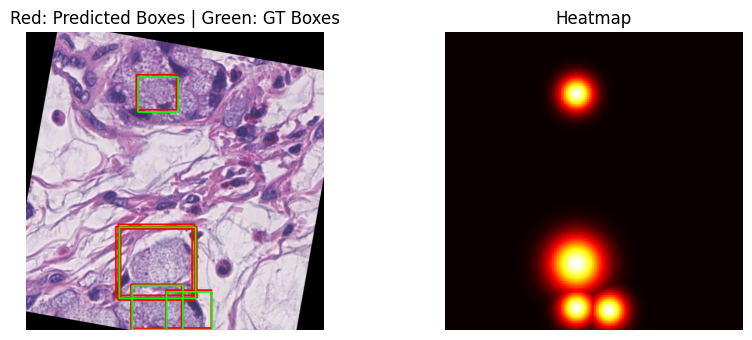

In [7]:
# Get image and corresponding data from dataset
image, hm, regr, gt_boxes, flag = dataset[15]
print(image.shape)  # (3, H, W) – check image size
print(f'Flag: {flag}')

# Unnormalize image (if normalized during preprocessing)
image = unnormalize_tensor(image.clone())

# Get predicted boxes from heatmap and regression outputs
pred_boxes, _ = pred2box(hm, regr)

# Convert tensor image to numpy
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Copy image for drawing boxes
image_copy = image.copy()

# Draw predicted boxes in red
for box in pred_boxes:
    x, y, w, h = map(int, box)
    cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Draw ground truth boxes in green
for box in gt_boxes:
    x1, y1, w, h = map(int, box)
    cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

# Create subplot for visualization
fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))

# Display image with predicted and GT boxes
axs[0].imshow(image_copy)
axs[0].set_title("Red: Predicted Boxes | Green: GT Boxes")
axs[0].axis('off')

# Display raw heatmap
axs[1].imshow(hm, cmap='hot')
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

## 2. Data Loader

In [8]:
# Paths
dataset_base_dir = "/content/drive/MyDrive/Dissertation_Chatwipa/dataset"

# Train and Validation dataset
train_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "train"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/train"),
    transform=train_transform
)

val_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "val"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/val"),
    transform=val_test_transform
)

# Test dataset
test_dataset = SignetRingCellPatchCenterNetDataset(
    image_dir=os.path.join(dataset_base_dir, "test"),
    annotation_dir=os.path.join(dataset_base_dir, "annotations/test"),
    transform=val_test_transform
)

# Define a custom collate function to handle the variable-length gt_boxes
def custom_collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    hms = torch.stack([torch.from_numpy(item[1]).float() for item in batch])
    regrs = torch.stack([torch.from_numpy(item[2]).float() for item in batch])
    gt_boxes = [item[3] for item in batch]
    flags = [item[4] for item in batch]

    return images, hms, regrs, gt_boxes, flags

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate_fn)

#### 2.1 Check `train_loader` function

In [9]:
for batch in train_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes, _ = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 16 images


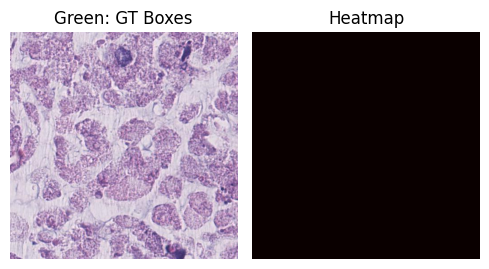

In [10]:
# Convert image to numpy
image = unnormalize_tensor(images[0].clone())
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Copy image for drawing boxes
image_copy = image.copy()

# Draw ground truth boxes in green
for box in gt_boxes[0]:
    x1, y1, w, h = map(int, box)
    cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

# Create subplot for visualization
fig, axs = plt.subplots(1, 2, figsize=(5, 8))

# Display image with predicted and GT boxes
axs[0].imshow(image_copy)
axs[0].set_title("Green: GT Boxes")
axs[0].axis('off')

# Display raw heatmap
axs[1].imshow(hm[0], cmap='hot')
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

#### 2.2 Check `val_loader` function

In [11]:
for batch in val_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes, _  = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 16 images


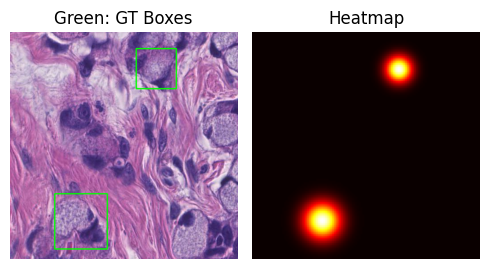

In [12]:
# Convert image to numpy
image = unnormalize_tensor(images[0].clone())
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Copy image for drawing boxes
image_copy = image.copy()

# Draw ground truth boxes in green
for box in gt_boxes[0]:
    x1, y1, w, h = map(int, box)
    cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

# Create subplot for visualization
fig, axs = plt.subplots(1, 2, figsize=(5, 8))

# Display image with predicted and GT boxes
axs[0].imshow(image_copy)
axs[0].set_title("Green: GT Boxes")
axs[0].axis('off')

# Display raw heatmap
axs[1].imshow(hm[0], cmap='hot')
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

#### 2.3 Check `test_loader` function

In [13]:
for batch in test_loader:
    if batch is None:
        continue
    images, hm, regr, gt_boxes, _  = batch
    print(f"Loaded batch with {len(images)} images")
    break

Loaded batch with 16 images


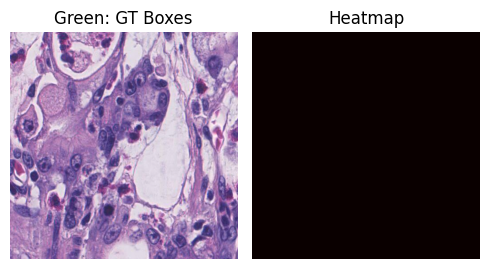

In [14]:
# Convert image to numpy
image = unnormalize_tensor(images[0].clone())
image = image.clone().permute(1, 2, 0).numpy()
image = (image * 255).astype(np.uint8)

# Copy image for drawing boxes
image_copy = image.copy()

# Draw ground truth boxes in green
for box in gt_boxes[0]:
    x1, y1, w, h = map(int, box)
    cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

# Create subplot for visualization
fig, axs = plt.subplots(1, 2, figsize=(5, 8))

# Display image with predicted and GT boxes
axs[0].imshow(image_copy)
axs[0].set_title("Green: GT Boxes")
axs[0].axis('off')

# Display raw heatmap
axs[1].imshow(hm[0], cmap='hot')
axs[1].set_title("Heatmap")
axs[1].axis('off')

plt.tight_layout()
plt.show()

## 3. Model Training

### 3.1 CenterNet Model

- The model is based on [CenterNet Baseline](https://www.kaggle.com/hocop1/centernet-baseline/data).

#### CenterNet class

In [15]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ELU(inplace=True), # Change from ReLU to ELU

            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ELU(inplace=True), # Change from ReLU to ELU
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

class centernet(nn.Module):
    def __init__(self, n_classes=1, model_name="resnet34"):
        super(centernet, self).__init__()

        # Create model backbone
        if model_name == "resnet34":
            basemodel = torchvision.models.resnet34(weights=ResNet34_Weights.DEFAULT)
            self.num_ch = 512
        elif model_name == "resnet18":
            basemodel = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
            self.num_ch = 512

        # Remove the last two layers (average pooling and linear layer)
        self.base_model = nn.Sequential(*list(basemodel.children())[:-2])

        # Freeze earlier layers except layer3 and layer4
        for name, param in basemodel.named_parameters():
            if "layer3" in name or "layer4" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        self.up1 = up(self.num_ch, 512)
        self.up2 = up(512, 256)
        self.up3 = up(256, 256)

        # Output classification
        self.outc = nn.Conv2d(256, n_classes, 1)

        # Output residue
        self.outr = nn.Conv2d(256, 2, 1)

    def forward(self, x):
        x = self.base_model(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        outc = self.outc(x)
        outr = self.outr(x)
        return outc, outr

#### Loss function

In [16]:
# From centernet repo
# Modified focal loss to detect object centers via heatmap
def neg_loss(pred, gt, pos_gamma=3, neg_gamma=4):
  ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
      Args:
      pred: (B, 1, H, W)
      gt: (B, 1, H, W)
      pos_gamma: focusing parameter for positive examples
      neg_gamma: focusing parameter for negative examples
    '''

  pred = pred.unsqueeze(1).float()
  pred = torch.clamp(pred, min=1e-4, max=1 - 1e-4)
  gt = gt.unsqueeze(1).float()

  pos_inds = gt.eq(1).float() # Locations where there is a true object center
  neg_inds = gt.lt(1).float()  # All other pixels
  neg_weights = torch.pow(1 - gt, 4) # Higher weight for pixels farther from center

  loss = 0

  pos_loss = torch.log(pred + 1e-12) * torch.pow(1 - pred, pos_gamma) * pos_inds
  neg_loss = torch.log(1 - pred + 1e-12) * torch.pow(pred, neg_gamma) * neg_weights * neg_inds

  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = (loss - neg_loss)
  else:
    loss = loss - (pos_loss + neg_loss) / (num_pos + 1e-4)

  return loss

# Smooth L1 regression loss for offsets, widths, etc.
def _reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
      regr: (B, N, 2)
      gt_regr: (B, N, 2)
      mask: (B, N)
  '''
  num = mask.float().sum()
  mask = mask.unsqueeze(2).expand_as(gt_regr)  # (B, N, 2)

  regr = regr * mask
  gt_regr = gt_regr * mask

  regr_loss = nn.functional.smooth_l1_loss(regr, gt_regr, reduction='sum')
  regr_loss = regr_loss / (num + 1e-4)

  return regr_loss


def centerloss(prediction, mask, regr, weight=100, size_average=True):
    """
    Combines heatmap focal loss and regression L1 loss into a total loss.

    Args:
        prediction: (B, 3, H, W) where [:, 0] = heatmap, [:, 1:] = regr
        mask: (B, H, W) – binary mask for object centers
        regr: (B, 2, H, W) – regression ground truth
        weight: float – weight of regression loss
        size_average: bool – average the final loss across batch

    Returns:
        total_loss, mask_loss, regr_loss
    """

    # Mask loss
    pred_mask = prediction[:, 0]
    mask_loss = neg_loss(pred_mask, mask)

    # Regression loss
    pred_regr = prediction[:, 1:]
    # Flatten tensors for _reg_loss: (B, 2, H, W) -> (B, H*W, 2)
    pred_regr_flat = pred_regr.permute(0, 2, 3, 1).reshape(pred_regr.size(0), -1, 2)
    regr_gt_flat = regr.permute(0, 2, 3, 1).reshape(regr.size(0), -1, 2)
    mask_flat = mask.view(mask.size(0), -1)  # (B, H*W)

    # Regression loss using helper
    regr_loss = _reg_loss(pred_regr_flat, regr_gt_flat, mask_flat) * weight

    # Total loss (with weighting)
    total_loss = mask_loss + regr_loss

    if not size_average:
        total_loss *= prediction.shape[0]

    return total_loss, mask_loss, regr_loss

#### Evaluation function

In [17]:
# Convert bounding boxes from (x, y, w, h) format to (x1, y1, x2, y2) format.
def boxes_conversion_xy(boxes_x1y1wh):
    """
    Args:
        boxes: A set of bounding boxes in (x, y, width, height) format

    Returns:
        torch.Tensor: Bounding boxes in (x1, y1, x2, y2) format as a float32 tensor.
                      (x1, y1) is the top-left corner, (x2, y2) is the bottom-right.
    """

    if isinstance(boxes_x1y1wh, torch.Tensor):
        boxes_x1y1x2y2 = boxes_x1y1wh.clone()
        boxes_x1y1x2y2[:, 2] = boxes_x1y1x2y2[:, 0] + boxes_x1y1x2y2[:, 2]  # x2 = x + w
        boxes_x1y1x2y2[:, 3] = boxes_x1y1x2y2[:, 1] + boxes_x1y1x2y2[:, 3]  # y2 = y + h
    else:
        boxes_x1y1wh = np.array(boxes_x1y1wh)
        boxes_x1y1x2y2 = boxes_x1y1wh.copy()
        boxes_x1y1x2y2[:, 2] = boxes_x1y1x2y2[:, 0] + boxes_x1y1x2y2[:, 2]
        boxes_x1y1x2y2[:, 3] = boxes_x1y1x2y2[:, 1] + boxes_x1y1x2y2[:, 3]
        boxes_x1y1x2y2 = torch.tensor(boxes_x1y1x2y2, dtype=torch.float32)

    return boxes_x1y1x2y2

def match_predictions(pred_boxes, gt_boxes, positive_flag):
    """
    Args:
        pred_boxes: List of predicted boxes in xywh
        gt_boxes: List of ground truth boxes in xywh
        positive_flag: True if image has GT boxes (positive sample), else False
    Returns:
        tp_pos, fp_pos, tn_pos, fn_pos, fp_neg, tn_neg
    """
    tp_pos = fp_pos = tn_pos = fn_pos = fp_neg = tn_neg = 0

    # ---- Positive Images: Precision and Recall ---- #
    if positive_flag:
        # No label from both gound-truth and prediction -> TN
        if len(gt_boxes) == 0 and len(pred_boxes) == 0:
            tp_pos, fp_pos, tn_pos, fn_pos = 0, 0, 1, 0
            return tp_pos, fp_pos, tn_pos, fn_pos, fp_neg, tn_neg

        # No label from ground-truth -> all preds are FP
        if len(gt_boxes) == 0:
            tp_pos, fp_pos, tn_pos, fn_pos = 0, len(pred_boxes), 0, 0
            return tp_pos, fp_pos, tn_pos, fn_pos, fp_neg, tn_neg

        # No label from prediction -> all preds are FN
        if len(pred_boxes) == 0:
            tp_pos, fp_pos, tn_pos, fn_pos = 0, 0, 0, len(gt_boxes)
            return tp_pos, fp_pos, tn_pos, fn_pos, fp_neg, tn_neg

        # Convert bounding boxes from (x, y, w, h) format to (x1, y1, x2, y2) format
        pred_boxes_xyxy = boxes_conversion_xy(pred_boxes)
        gt_boxes_xyxy = boxes_conversion_xy(gt_boxes)

        # Calculate ious from library
        ious = box_iou(gt_boxes_xyxy, pred_boxes_xyxy)  # return [num_gt, num_pred]

        # Initialize tensor
        matched_gt = torch.zeros(len(gt_boxes), dtype=torch.bool)
        matched_pred = torch.zeros(len(pred_boxes), dtype=torch.bool)
        for j in range(ious.size(1)):  # loop all prediction
            for i in range(ious.size(0)):  # loop all ground-truth
                # skips already-matched ground truth boxes
                if not (matched_gt[i]) and (ious[i, j] >= 0.3):
                    matched_gt[i] = True
                    matched_pred[j] = True
                    break

        tp_pos = matched_gt.sum().item()
        fp_pos = (~matched_pred).sum().item()
        fn_pos = (~matched_gt).sum().item()

    # ---- Negative Images: Normal Region False Positive ---- #
    else:  # only TN or FP
        tn_neg = 1 if len(pred_boxes) == 0 else 0
        fp_neg = 0 if tn_neg == 1 else len(pred_boxes)

    return tp_pos, fp_pos, tn_pos, fn_pos, fp_neg, tn_neg

def pool_numpy(data, size=3):
    max_filtered = maximum_filter(data, size=size, mode='constant')
    return np.where(data == max_filtered, data, 0)

def compute_metrics(tp_pos, fp_pos, tn_pos, fn_pos, fp_neg, total_gt_boxes):

    # ---- Positive Images : Precision and Recall ---- #
    precision = tp_pos / (tp_pos + fp_pos + 1e-6)
    recall = tp_pos / (tp_pos + fn_pos + 1e-6)
    instance_recall = tp_pos / total_gt_boxes
    f1 = 2 * precision * instance_recall / (precision + instance_recall + 1e-6)

    # ---- Negative Images: FPs ---- #
    normal_region_fp = fp_neg
    normal_fp_score = max((100 - normal_region_fp), 0)

    return {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Instance Recall': instance_recall,
        'Normal Region FP': fp_neg,
        'FP Score': normal_fp_score
    }

def compute_froc_valid_recall(predictions_by_thresh, gt_boxes_list, flag_list, total_fp_neg,
                              thresholds, fp_levels=[1, 2, 4, 8, 16, 32]):
    """
    Computes FROC using Valid Recall metric.

    Args:
        predictions_by_thresh: dict of {threshold: list of per-image predicted boxes}
        gt_boxes_list: list of ground truth boxes per image
        flag_list: list of booleans indicating whether the image has positive ground truth
        thresholds: list of confidence thresholds
        fp_levels: list of FP/image levels (default as per DigestPath2019)

    Returns:
        froc_score: average Valid Recall at the specified FP/image levels
        recalls_at_fp: recall values at valid thresholds for each FP level
    """

    image_count = len(flag_list)
    recalls_per_fp_level = []
    total_gt_boxes = sum(len(boxes) for boxes in gt_boxes_list)
    seen_levels = set()

    for threshold in thresholds:
        preds_list = predictions_by_thresh[threshold]

        total_tp_pos = total_fp_pos = total_tn_pos = total_fn_pos = total_fp_neg = total_tn_neg = 0

        for boxes_sorted, gt_boxes, flag in zip(preds_list, gt_boxes_list, flag_list):
            tp_pos, fp_pos, tn_pos, fn_pos, fp_neg, tn_neg = match_predictions(boxes_sorted, gt_boxes, flag)
            total_tp_pos += tp_pos
            total_fp_pos += fp_pos
            total_tn_pos += tn_pos
            total_fn_pos += fn_pos
            total_fp_neg += fp_neg
            total_tn_neg += tn_neg

        metric = compute_metrics(total_tp_pos, total_fp_pos, total_tn_pos, total_fn_pos, total_fp_neg, total_gt_boxes)
        instance_recall = metric['Instance Recall']
        precision = metric['Precision']
        normal_region_fp = metric['Normal Region FP']

        # Check if threshold gives valid precision and acceptable FP/image
        for level in fp_levels:
            if normal_region_fp <= level and precision >= 0.2 and level not in seen_levels:
                recalls_per_fp_level.append(instance_recall)
                seen_levels.add(level)
                break  # Only one threshold per FP level

        if len(seen_levels) == len(fp_levels):
            break  # Collected recall for all levels

    # If some levels were not matched, pad with 0 recall
    while len(recalls_per_fp_level) < len(fp_levels):
        recalls_per_fp_level.append(0.0)

    froc_score = sum(recalls_per_fp_level) / len(fp_levels)

    return froc_score, dict(zip(fp_levels, recalls_per_fp_level))

### 3.2 Pseudo-label generation

#### Teacher model structure

In [20]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ELU(inplace=True), # Change from ReLU to ELU
            nn.Dropout2d(p=0.3),

            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ELU(inplace=True), # Change from ReLU to ELU
            nn.Dropout2d(p=0.3),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
            # input is CHW
            diffY = x2.size()[2] - x1.size()[2]
            diffX = x2.size()[3] - x1.size()[3]

            x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                            diffY // 2, diffY - diffY//2))
        else:
            x = x1
        x = self.conv(x)
        return x

class centernet_teacher(nn.Module):
    def __init__(self, n_classes=1, model_name="resnet34"):
        super(centernet_teacher, self).__init__()

        # Create model backbone
        if model_name == "resnet50":
            basemodel = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
            self.num_ch = 2048
        elif model_name == "resnet34":
            basemodel = torchvision.models.resnet34(weights=ResNet34_Weights.DEFAULT)
            self.num_ch = 512
        elif model_name == "resnet18":
            basemodel = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
            self.num_ch = 512

        # Remove the last two layers (average pooling and linear layer)
        self.base_model = nn.Sequential(*list(basemodel.children())[:-2])

        # Freeze earlier layers except layer3 and layer4
        for name, param in basemodel.named_parameters():
            if "layer3" in name or "layer4" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        if self.num_ch == 2048:
            self.up1 = up(self.num_ch, 1024)
            self.up2 = up(1024, 512)
            self.up3 = up(512, 256)
        else:
            self.up1 = up(self.num_ch, 512)
            self.up2 = up(512, 256)
            self.up3 = up(256, 256)

        # Output classification
        self.outc = nn.Conv2d(256, n_classes, 1)

        # Output residue
        self.outr = nn.Conv2d(256, 2, 1)

    def forward(self, x):
        x = self.base_model(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        outc = self.outc(x)
        outr = self.outr(x)
        return outc, outr

#### Teacher model checkpoint

In [22]:
teacher_model = centernet_teacher(model_name='resnet50')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)

model_path = "/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/adam50_checkpoints_20250627_173310/best_model.pth"
checkpoint = torch.load(model_path)
# checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
teacher_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### Generate pseudo-label

In [24]:
def plot_pseudo_images(image, pseudo_boxes_gt, boxes_gt, pseudo_hm):
    # ----- Visualization ----- #
    # Unnormalize image (if normalized during preprocessing)
    image = unnormalize_tensor(image.clone())

    # Convert tensor image to numpy
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)

    # Copy image for drawing boxes
    image_copy = image.copy()

    # Draw pseudo-label boxes in red
    for box in pseudo_boxes_gt:
        x, y, w, h = map(int, box)
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Draw ground truth boxes in green
    for box in boxes_gt:
        x1, y1, w, h = map(int, box)
        cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

    # Create subplot for visualization
    fig, axs = plt.subplots(1, 2, figsize=(5, 3.5))  # 2 columns: image + heatmap

    # Display image with pseudo and GT boxes
    axs[0].imshow(image_copy)
    axs[0].set_title("Red: Pseudo Boxes | Green: GT Boxes", fontsize = 10)
    axs[0].axis('off')

    # Display heatmap
    axs[1].imshow(pseudo_hm, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
    axs[1].set_title("Pseudo Heatmap", fontsize = 10)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

In [25]:
def generate_pseudo_label(teacher_model, img_batch, hm_batch_gt, regr_batch_gt, box_gt_batch, flags_batch, plot = False):

    pseudo_hm_batch, pseudo_regr_batch = [], []

    # Move batch tensors to the device (GPU or CPU)
    img_batch = img_batch.to(device)
    hm_batch_gt = hm_batch_gt.to(device)
    regr_batch_gt = regr_batch_gt.to(device)

   # Helper functions to check box containment
    def is_inside(box_a, box_b):
        # Convert xywh to xyxy
        ax1, ay1 = box_a[0], box_a[1]
        ax2, ay2 = box_a[0] + box_a[2], box_a[1] + box_a[3]

        bx1, by1 = box_b[0], box_b[1]
        bx2, by2 = box_b[0] + box_b[2], box_b[1] + box_b[3]

        return (ax1 >= bx1) and (ay1 >= by1) and (ax2 <= bx2) and (ay2 <= by2)

    def is_covering(box_a, box_b):
        # Convert xywh to xyxy
        ax1, ay1 = box_a[0], box_a[1]
        ax2, ay2 = box_a[0] + box_a[2], box_a[1] + box_a[3]

        bx1, by1 = box_b[0], box_b[1]
        bx2, by2 = box_b[0] + box_b[2], box_b[1] + box_b[3]

        return (ax1 <= bx1) and (ay1 <= by1) and (ax2 >= bx2) and (ay2 >= by2)

    # ----- Generate pseudo-label from teacher model ----- #
    with torch.no_grad():
        # Forward pass through the model
        hm_teacher_batch, regr_teacher_batch = teacher_model(img_batch)
        hm_teacher_batch = torch.sigmoid(hm_teacher_batch)

        # Iterate through each image in the batch
        for i, (img, hm_teacher, regr_teacher, boxes_gt, flag) in enumerate(zip(img_batch, hm_teacher_batch, regr_teacher_batch, box_gt_batch, flags_batch)):
            if flag == 1:
                # Preprocess predictions
                hm_teacher = pool_numpy(hm_teacher.cpu().numpy().squeeze(0))  # Apply pooling to smoothen heatmap
                regr_teacher = regr_teacher.cpu().numpy()

                # Get predicted bounding boxes and scores from heatmap and regression output
                boxes_teacher, scores = pred2box(hm_teacher, regr_teacher, thresh=0.7)

                if len(boxes_teacher) != 0:
                    # Convert to tensors for NMS
                    boxes_tensor = torch.tensor(boxes_teacher, dtype=torch.float32)
                    scores_tensor = torch.tensor(scores, dtype=torch.float32)

                    # Apply Non-Maximum Suppression
                    boxes_xyxy = boxes_conversion_xy(boxes_tensor)
                    keep = nms(boxes_xyxy, scores_tensor, iou_threshold=0.3)

                    # Filter top boxes and scores
                    boxes_sorted = boxes_teacher[keep]
                    scores_sorted = scores[keep]

                    # Filter by score > 0.8
                    high_conf_mask = scores_sorted > 0.8
                    boxes_teacher_confidence = boxes_sorted[high_conf_mask]

                    # Select unmatched teacher boxes
                    if len(boxes_gt) > 0:
                        # Convert ground truth and teacher boxes to xyxy
                        boxes_gt_xyxy = boxes_conversion_xy(boxes_gt)
                        boxes_teacher_xyxy = boxes_conversion_xy(boxes_teacher_confidence)

                        # Calculate IoU
                        ious = box_iou(boxes_teacher_xyxy, boxes_gt_xyxy)
                        max_ious, _ = ious.max(dim=1)
                        unmatched_mask = max_ious < 0.3
                        pseudo_boxes_gt = boxes_teacher_confidence[unmatched_mask.numpy()].tolist() + boxes_gt

                        remove_list = []
                        for box in pseudo_boxes_gt:
                          for box_gt in boxes_gt:
                            if is_inside(box, box_gt) or is_covering(box, box_gt):
                              remove_list.append(box)

                        pseudo_boxes_gt = [box for box in pseudo_boxes_gt if box not in remove_list]
                        pseudo_boxes_gt = pseudo_boxes_gt + boxes_gt
                    else:
                        pseudo_boxes_gt = boxes_teacher_confidence.tolist()  # All are unmatched if no GT

                    # Convert pseudo boxes to DataFrame format
                    pseudo_boxes_df = pd.DataFrame(pseudo_boxes_gt, columns=['x', 'y', 'w', 'h'])

                    # Generate pseudo-label heatmap and regression maps
                    pseudo_hm, pseudo_regr = make_hm_regr(pseudo_boxes_df)

                    # ---- Visualization ---- #
                    if plot:
                      plot_pseudo_images(img, pseudo_boxes_gt, boxes_gt, pseudo_hm)

                else:
                    # Original label
                    pseudo_boxes_gt = boxes_gt
                    pseudo_boxes_df = pd.DataFrame(pseudo_boxes_gt, columns=['x', 'y', 'w', 'h'])
                    pseudo_hm, pseudo_regr = make_hm_regr(pseudo_boxes_df)

                    # ---- Visualization ---- #
                    if plot:
                      plot_pseudo_images(img, pseudo_boxes_gt, boxes_gt, pseudo_hm)

            else:
                # Original label
                pseudo_boxes_gt = boxes_gt
                pseudo_boxes_df = pd.DataFrame(pseudo_boxes_gt, columns=['x', 'y', 'w', 'h'])
                pseudo_hm, pseudo_regr = make_hm_regr(pseudo_boxes_df)

                # ---- Visualization ---- #
                if plot:
                  plot_pseudo_images(img, pseudo_boxes_gt, boxes_gt, pseudo_hm)

            # Save pseudo hm and regr in batch
            pseudo_hm_batch = pseudo_hm_batch + [pseudo_hm]
            pseudo_regr_batch = pseudo_regr_batch + [pseudo_regr]

            # ----- End of pseudo-label generation ----- #

    # Create tensor
    pseudo_hm_batch = torch.from_numpy(np.array(pseudo_hm_batch)).float()
    pseudo_regr_batch = torch.from_numpy(np.array(pseudo_regr_batch)).float()

    return pseudo_hm_batch, pseudo_regr_batch

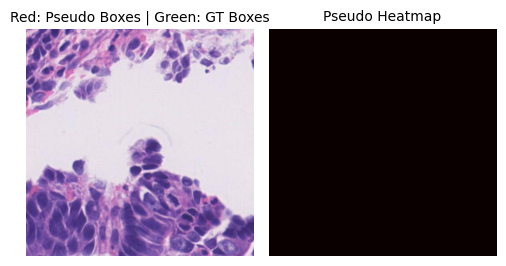

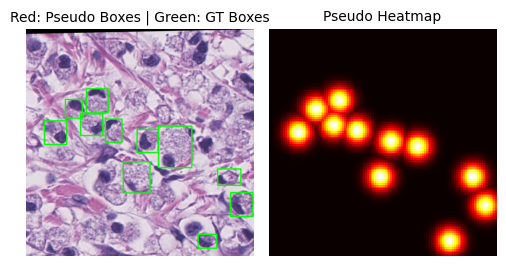

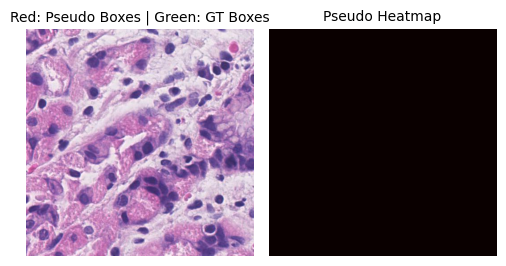

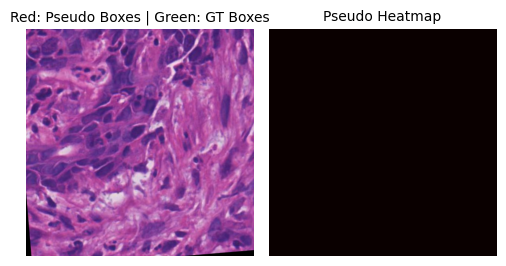

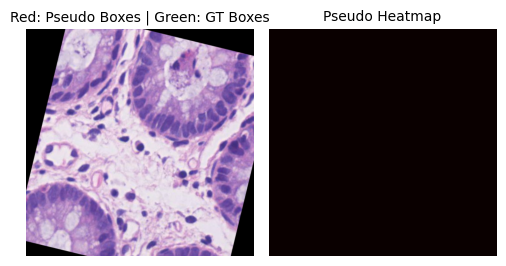

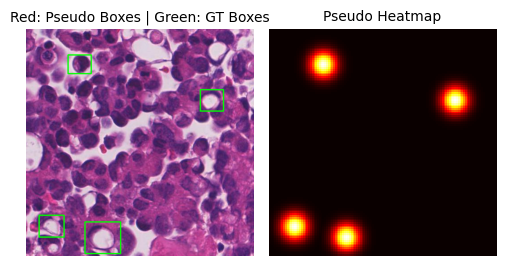

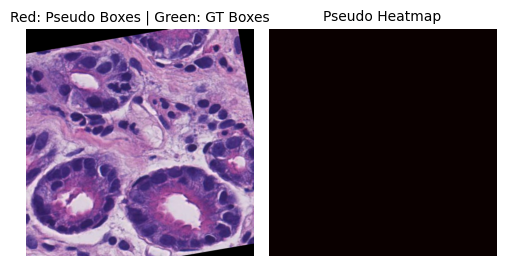

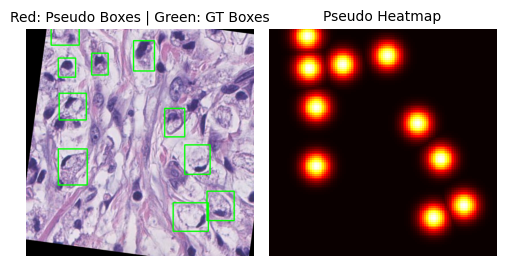

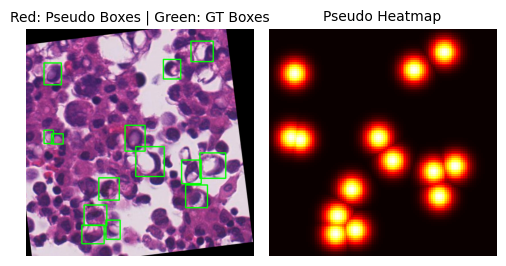

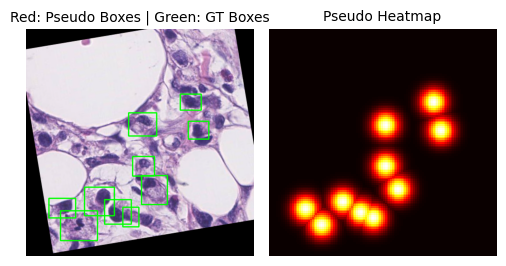

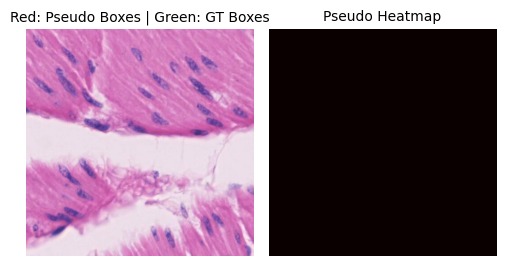

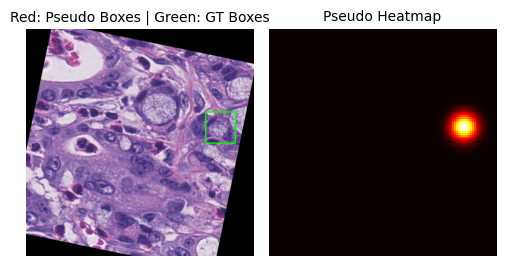

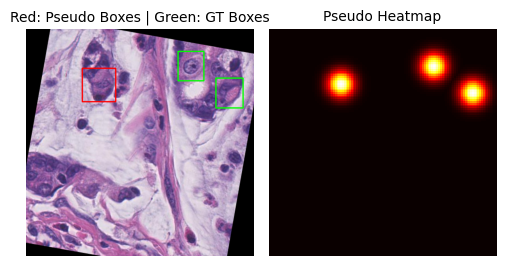

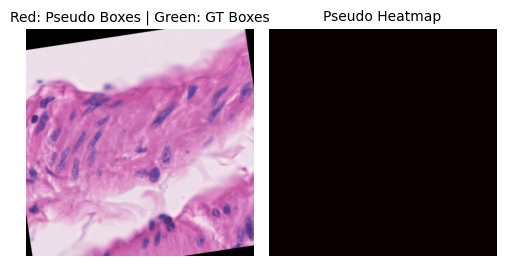

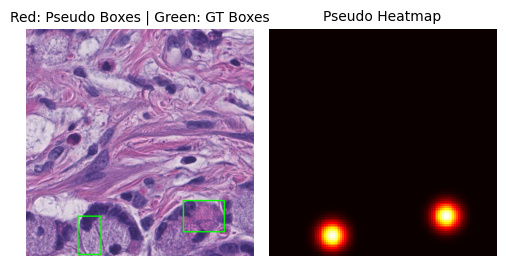

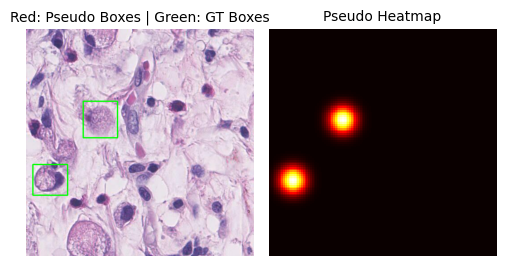

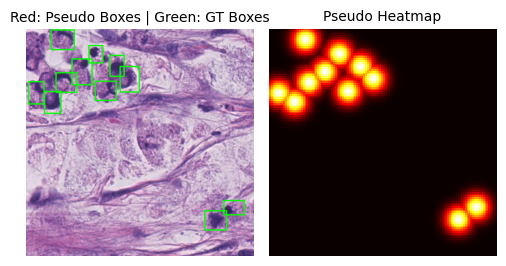

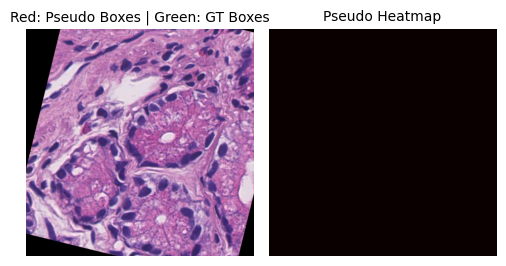

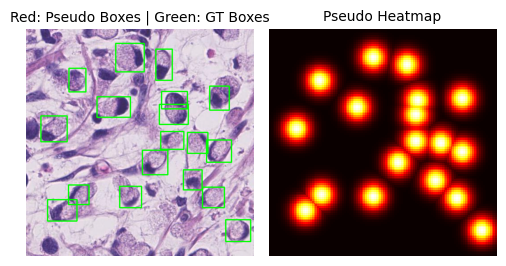

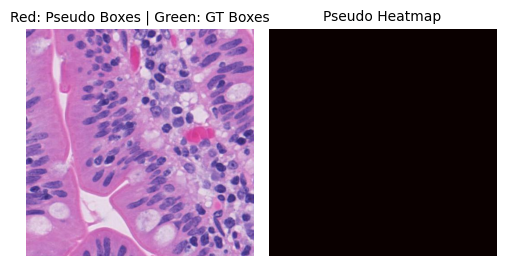

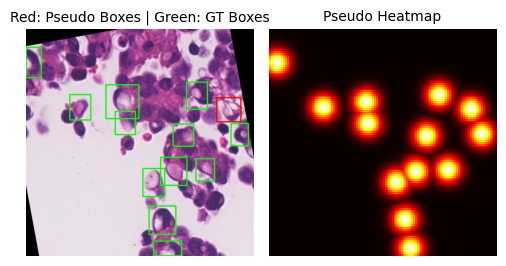

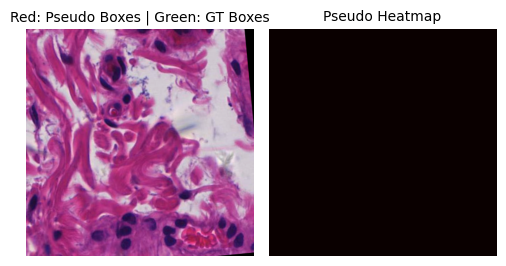

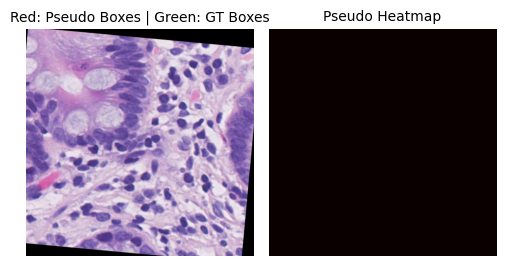

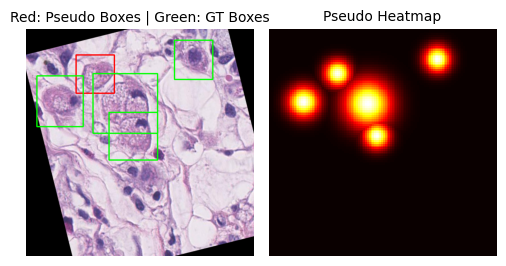

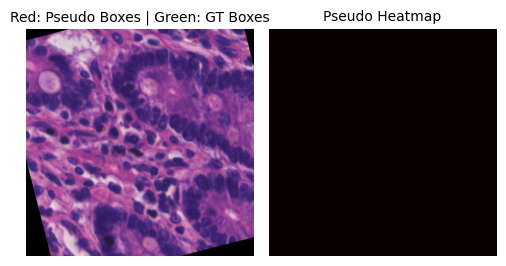

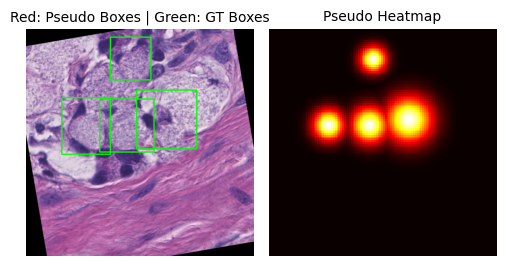

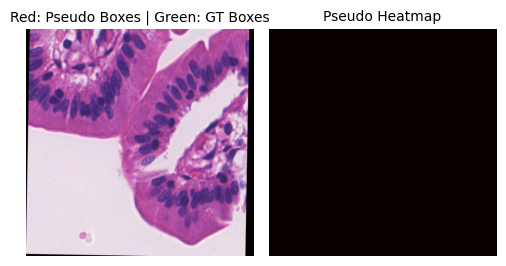

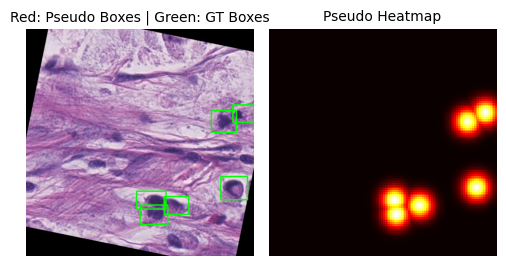

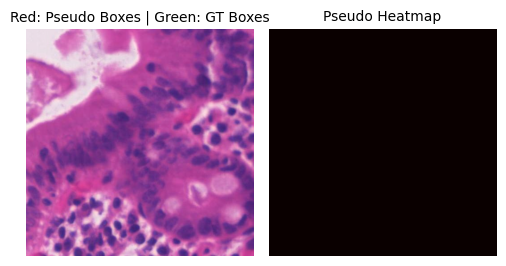

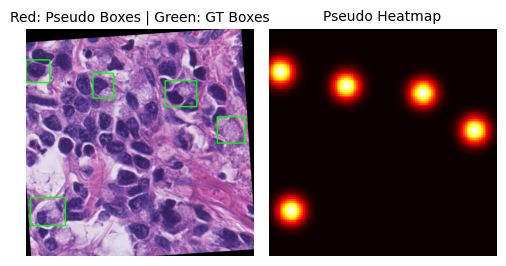

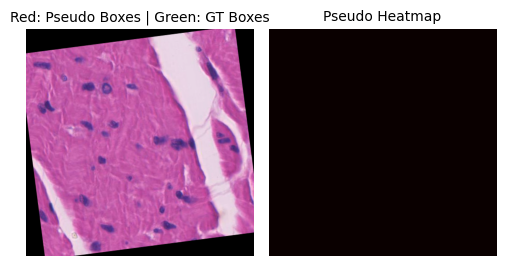

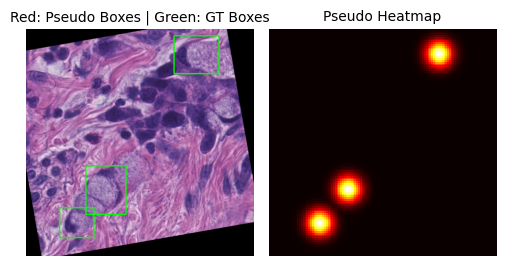

In [28]:
teacher_model.eval()

for batch_idx, (img_batch, hm_batch_gt, regr_batch_gt, box_gt_batch, flags_batch) in enumerate(train_loader):
    if batch_idx > 1:
       break
    pseudo_hm_batch, pseudo_regr_batch = generate_pseudo_label(teacher_model, img_batch, hm_batch_gt, regr_batch_gt, box_gt_batch, flags_batch, plot = True)

In [29]:
pseudo_hm_batch.shape, hm_batch_gt.shape

(torch.Size([16, 128, 128]), torch.Size([16, 128, 128]))

### 3.3 Training Function

#### Define validation function

In [41]:
def validate():
    # Set model to evaluation mode
    student_model.eval()

    # Initialize loss trackers
    running_loss = 0.0
    running_mask = 0.0
    running_regr = 0.0

    # Initialize counters for evaluation metrics
    total_tp_pos = total_fp_pos = total_tn_pos = total_fn_pos = total_fp_neg = total_tn_neg = 0
    gt_boxes_list = []

    # Disable gradient computations during validation
    with torch.no_grad():
        for idx, (img_batch, hm_gt_batch, regr_gt_batch, box_gt_batch, flags_batch) in enumerate(val_loader):

            # Move inputs to the correct device
            img_batch = img_batch.to(device)
            hm_gt_batch = hm_gt_batch.to(device)
            regr_gt_batch = regr_gt_batch.to(device)

            # Forward pass
            hm_pred_batch, regr_pred_batch = student_model(img_batch)
            hm_pred_batch = torch.sigmoid(hm_pred_batch)  # Apply sigmoid to get probabilities

            # Plot GT and predicted heatmaps for the first batch every 2 epochs
            if idx == 0 and (epoch % 2 == 0 or epoch == 0):
                plt.subplot(1, 2, 1)
                plt.imshow(hm_gt_batch[0].squeeze().cpu().numpy(), cmap='hot')
                plt.title('GT Heatmap')

                plt.subplot(1, 2, 2)
                plt.imshow(hm_pred_batch[0].squeeze().cpu().numpy(), cmap='hot')
                plt.title('Pred Heatmap')
                plt.show()

            # Concatenate predicted heatmaps and regression maps for loss computation
            preds = torch.cat((hm_pred_batch, regr_pred_batch), dim=1)
            loss, mask_loss, regr_loss = centerloss(preds, hm_gt_batch, regr_gt_batch)

            # Update running loss totals
            running_loss += loss.item()
            running_mask += mask_loss.item()
            running_regr += regr_loss.item()

            # Process each image in the batch
            for i, (img, hm, regr, gt_boxes, flag) in enumerate(zip(img_batch, hm_pred_batch, regr_pred_batch, box_gt_batch, flags_batch)):

                # Post-process predicted heatmap and regression outputs
                hm = pool_numpy(hm.cpu().numpy().squeeze(0))  # Apply local max pooling
                regr = regr.cpu().numpy()

                # Convert predictions to bounding boxes and scores
                boxes, scores = pred2box(hm, regr, thresh=0.3)

                # Apply NMS if there are any predicted boxes
                boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
                scores_tensor = torch.tensor(scores, dtype=torch.float32)
                if boxes_tensor.numel() > 0:
                    boxes_xyxy = boxes_conversion_xy(boxes_tensor)  # Convert to (x1, y1, x2, y2) format
                    keep = nms(boxes_xyxy, scores_tensor, iou_threshold=0.3)  # Apply NMS
                    boxes_sorted = boxes_tensor[keep].numpy()
                    scores_sorted = scores_tensor[keep].numpy()
                else:
                    boxes_sorted = np.empty((0, 4))
                    scores_sorted = np.empty((0,))

                # Match predicted boxes with ground truth to compute evaluation metrics
                tp_pos, fp_pos, tn_pos, fn_pos, fp_neg, tn_neg = match_predictions(boxes_sorted, gt_boxes, flag)
                total_tp_pos += tp_pos
                total_fp_pos += fp_pos
                total_tn_pos += tn_pos
                total_fn_pos += fn_pos
                total_fp_neg += fp_neg
                total_tn_neg += tn_neg

                # Store ground truth boxes for later analysis or metric calculation
                gt_boxes_list.append(gt_boxes)

    # Compute average losses
    avg_loss = running_loss / len(val_loader)
    avg_mask = running_mask / len(val_loader)
    avg_regr = running_regr / len(val_loader)

    # Print validation loss results
    print(f"\nValidation loss      : {avg_loss:.4f}")
    print(f"Validation mask loss : {avg_mask:.4f}")
    print(f"Validation regr loss : {avg_regr:.4f}")

    # Compute total number of ground truth boxes across all images
    total_gt_boxes = sum(len(boxes) for boxes in gt_boxes_list)

    # Compute precision, recall, F1, and FP metrics
    metrics = compute_metrics(
        total_tp_pos,
        total_fp_pos,
        total_tn_pos,
        total_fn_pos,
        total_fp_neg,
        total_gt_boxes
    )

    # Print core evaluation metrics
    print(f"Precision:        {metrics['Precision']:.4f}")
    print(f"Recall:           {metrics['Recall']:.4f}")
    print(f"Instance Recall:  {metrics['Instance Recall']:.4f}")
    print(f"F1 Score:         {metrics['F1 Score']:.4f}")
    print(f"Normal Region FP: {metrics['Normal Region FP']}")

    return avg_loss, avg_mask, avg_regr, metrics

#### Define training function

In [58]:
def train_student(epoch, teacher_model, student_model,
                  save_dir, best_loss, best_f1, epochs_no_improve, early_stop_patience):

    # Set model to training mode
    student_model.train()
    teacher_model.eval()  # Freeze teacher
    print(f'\nEpoch {epoch + 1}/{epochs}')

    # Initialize loss value
    running_loss, running_mask, running_regr = 0.0, 0.0, 0.0

    # Start epoch timer
    epoch_start = time.time()

    # Iterate over batches
    for idx, (img, hm_gt, regr_gt, box_gt, flag_list) in enumerate(train_loader):

        # Move batch tensors to the device (GPU or CPU)
        img = img.to(device)
        hm_gt = hm_gt.to(device)
        regr_gt = regr_gt.to(device)

        # ----- Generate pseudo-label from teacher model ----- #
        hm_pseudo, regr_pseudo = generate_pseudo_label(teacher_model, img, hm_gt, regr_gt, box_gt, flag_list)
        hm_pseudo = hm_pseudo.to(device)
        regr_pseudo = regr_pseudo.to(device)

        # Reset gradients for new batch
        optimizer.zero_grad()

        # Forward pass: predict heatmap and regression outputs
        hm_pred, regr_pred = student_model(img)
        hm_pred = torch.sigmoid(hm_pred)

        # Concatenate heatmap and regression predictions along channel dimension
        preds = torch.cat((hm_pred, regr_pred), dim=1)

        # Compute combined loss (total, pseudo mask, and pseudo regression)
        loss, mask_loss, regr_loss = centerloss(preds, hm_pseudo, regr_pseudo)

        # Visualization: plot the GT and predicted heatmap for only first batch of epoch
        if idx == 0 and (epoch % 2 == 0 or epoch == 0):
            plt.subplot(1, 2, 1)
            plt.imshow(hm_gt[0].cpu().squeeze().numpy(), cmap='hot', vmin=0, vmax=1)
            plt.title('GT Heatmap')

            plt.subplot(1, 2, 2)
            plt.imshow(hm_pred[0].cpu().squeeze().detach().numpy(), cmap='hot', vmin=0, vmax=1)
            plt.title('Pred Heatmap')
            plt.show()

        # Backpropagation: compute gradients
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)

        # Update model weights
        optimizer.step()

        # Accumulate loss values for reporting
        running_loss += loss.item()
        running_mask += mask_loss.item()
        running_regr += regr_loss.item()

        # Compute running average losses for display
        train_loss = running_loss / (idx + 1)
        avg_mask = running_mask / (idx + 1)
        avg_regr = running_regr / (idx + 1)

   # Average losses over the entire epoch after training completes
    epoch_time = time.time() - epoch_start
    print(f"\nEpoch {epoch + 1} completed in {epoch_time:.2f} seconds.")
    print(f"Train loss : {running_loss / len(train_loader):.4f}")
    print(f"Train mask loss : {running_mask / len(train_loader):.4f}")
    print(f"Train regr loss : {running_regr / len(train_loader):.4f}")

    # Run validation after training epoch
    val_loss, avg_mask, avg_regr, metrics = validate()

    # Step learning rate scheduler based on validation loss
    # scheduler.step()
    scheduler.step(val_loss)

    # 🔍 Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current Learning Rate: {current_lr}')

    # Check if F1 improved
    f1 = metrics['F1 Score']
    if f1 > best_f1:
        print(f"F1 Score improved from {best_f1:.4f} to {f1:.4f}")
        best_f1 = f1
        epochs_no_improve = 0  # reset counter

        # Save best model
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': student_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss
        }, f'{save_dir}/best_model.pth')

    else:
        epochs_no_improve += 1
        print(f"No improvement in F1 Score for {epochs_no_improve} epoch(s)")

    # Save full checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': student_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss
        }, f'{save_dir}/checkpoint_epoch_{epoch + 1}.pth')

    # Early stopping condition
    if epochs_no_improve >= early_stop_patience:
        print(f"Early stopping triggered after {early_stop_patience} epochs without improvement.")
        early_stop_flag = True
    else:
        early_stop_flag = False

    return early_stop_flag, best_loss, best_f1, epochs_no_improve, train_loss, val_loss, f1

#### Define test function

In [43]:
def plot_pred_gt(image, boxes_pred, boxes_gt, hm_pred):
    # ----- Visualization ----- #
    # Unnormalize image (if normalized during preprocessing)
    image = unnormalize_tensor(image.clone())

    # Convert tensor image to numpy
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)

    # Copy image for drawing boxes
    image_copy = image.copy()

    # Draw pseudo-label boxes in red
    for box in boxes_pred:
        x, y, w, h = map(int, box)
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Draw ground truth boxes in green
    for box in boxes_gt:
        x1, y1, w, h = map(int, box)
        cv2.rectangle(image_copy, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)

    # Create subplot for visualization
    fig, axs = plt.subplots(1, 2, figsize=(5, 3.5))

    # Display image with pseudo and GT boxes
    axs[0].imshow(image_copy)
    axs[0].set_title("Red: Pred Boxes | Green: GT Boxes", fontsize = 10)
    axs[0].axis('off')

    # Display heatmap
    axs[1].imshow(hm_pred, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
    axs[1].set_title("Pred Heatmap", fontsize = 10)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

In [44]:
def test(model, test_loader, device, save_dir, plot=False):
    # Save path
    save_path = os.path.join(save_dir, 'test_results.csv')

    # Set model to evaluation mode
    model.eval()

    # Initialize counters for overall performance metrics
    total_tp_pos = total_fp_pos = total_tn_pos = total_fn_pos = total_fp_neg = total_tn_neg = 0

    # Structures for FROC evaluation
    thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
    predictions_by_thresh = {t: [] for t in thresholds}
    gt_boxes_list = []
    flag_list = []

    # Store per-image results for CSV logging
    result_rows = []

    with torch.no_grad():
        for batch_idx, (img_batch, hm_batch, regr_batch, box_gt_batch, flags_batch) in enumerate(test_loader):

            # Get images in batch
            img_batch = img_batch.to(device)

            # Forward pass through the model
            hms_pred, regrs_pred = model(img_batch)
            hms_pred = torch.sigmoid(hms_pred)

            # Iterate through each image in the batch
            for i, (img, hm, regr, gt_boxes, flag) in enumerate(zip(img_batch, hms_pred, regrs_pred, box_gt_batch, flags_batch)):
                index = batch_idx * test_loader.batch_size + i  # Global image index

                # Preprocess predictions
                hm = pool_numpy(hm.cpu().numpy().squeeze(0))
                regr = regr.cpu().numpy()

                # Get predicted bounding boxes and scores from heatmap and regression output
                boxes, scores = pred2box(hm, regr, 0.3)

                # Convert to tensors for NMS
                boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
                scores_tensor = torch.tensor(scores, dtype=torch.float32)

                # Apply Non-Maximum Suppression if any boxes are predicted
                if boxes_tensor.numel() > 0:
                    boxes_xyxy = boxes_conversion_xy(boxes_tensor)
                    keep = nms(boxes_xyxy, scores_tensor, iou_threshold=0.3)

                    # Filter top boxes and scores
                    boxes_sorted = boxes[keep.numpy()]
                    scores_sorted = scores[keep.numpy()]
                else:
                    # No predictions, initialize empty arrays
                    boxes_sorted = np.empty((0, 4))
                    scores_sorted = np.empty((0,))

                # Compute TP, FP, TN, FN for this image
                tp_pos, fp_pos, tn_pos, fn_pos, fp_neg, tn_neg = match_predictions(boxes_sorted, gt_boxes, flag)
                total_tp_pos += tp_pos
                total_fp_pos += fp_pos
                total_tn_pos += tn_pos
                total_fn_pos += fn_pos
                total_fp_neg += fp_neg
                total_tn_neg += tn_neg

                # Append per-image results for CSV
                result_rows.append({
                    'Image_Index': index,
                    'TP_positive': tp_pos,
                    'FP_positive': fp_pos,
                    'TN_positive': tn_pos,
                    'FN_positive': fn_pos,
                    'FP_negative': fp_neg,
                    'TN_negative': tn_neg,
                    'Num_Pred_Boxes': len(boxes_sorted),
                    'Num_GT_Boxes': len(gt_boxes),
                    'Positive_Flag': flag
                })

                # Plot images
                if plot and i == 0:
                    plot_pred_gt(img, boxes_sorted, gt_boxes, hm)

                ## ---- FROC Computation ---- ##
                gt_boxes_list.append(gt_boxes)
                flag_list.append(flag)

                # Group predictions by confidence threshold with NMS per threshold
                for t in thresholds:
                    # Get predicted bounding boxes and scores from heatmap and regression output
                    boxes, scores = pred2box(hm, regr, t)

                    # Convert to tensors for NMS
                    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
                    scores_tensor = torch.tensor(scores, dtype=torch.float32)

                    # Apply Non-Maximum Suppression if any boxes are predicted
                    if boxes_tensor.numel() > 0:
                        boxes_xyxy = boxes_conversion_xy(boxes_tensor)
                        keep = nms(boxes_xyxy, scores_tensor, iou_threshold=0.3)

                        # Filter top boxes and scores
                        boxes_sorted = boxes[keep.numpy()]
                        scores_sorted = scores[keep.numpy()]
                    else:
                        # No predictions, initialize empty arrays
                        boxes_sorted = np.empty((0, 4))
                        scores_sorted = np.empty((0,))

                    # Store for this threshold
                    predictions_by_thresh[t].append(boxes_sorted)

        total_gt_boxes = sum(len(boxes) for boxes in gt_boxes_list)
        metrics = compute_metrics(total_tp_pos, total_fp_pos, total_tn_pos, total_fn_pos, total_fp_neg, total_gt_boxes)
        froc_score, recall_at_fps = compute_froc_valid_recall(predictions_by_thresh, gt_boxes_list, flag_list, total_gt_boxes, thresholds)

        # Append summary row to CSV data
        result_rows.append({
            'Image_Index': 'Total',
            'TP': total_tp_pos,
            'FP': total_fp_pos,
            'TN': total_tn_pos,
            'FN': total_fn_pos,
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1_Score': metrics['F1 Score'],
            'FPs': metrics['FP Score'],
            'FROC_Score': froc_score
        })

        # # Save results to CSV file
        df = pd.DataFrame(result_rows)

        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        # df.to_csv(save_path, index=False)

        # Print final performance summary
        print(f"Precision: {metrics['Precision']:.4f}")
        print(f"Recall:    {metrics['Recall']:.4f}")
        print(f"Instance Recall: {metrics['Instance Recall']:.4f}")
        print(f"F1 Score:  {metrics['F1 Score']:.4f}")
        print(f"FPs:       {metrics['FP Score']:.4f}")
        print(f"FROC Score: {froc_score:.4f}")

    return metrics, froc_score, recall_at_fps, save_path

### 3.3 Train model

#### Load techer model

In [59]:
teacher_model = centernet_teacher(model_name='resnet50')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)

model_path = "/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/adam50_checkpoints_20250627_173310/best_model.pth"
checkpoint = torch.load(model_path)
# checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
teacher_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### Load student model

In [60]:
# Move model to device (GPU if available)
student_model = centernet(model_name='resnet18')
student_model.to(device)

# Optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=5e-5, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-7)

In [61]:
# Total parameters
total_params = sum(p.numel() for p in student_model.parameters())

# Trainable parameters
trainable_params = sum(p.numel() for p in student_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 18,851,139
Trainable parameters: 18,168,067


#### Training loop


Epoch 1/150


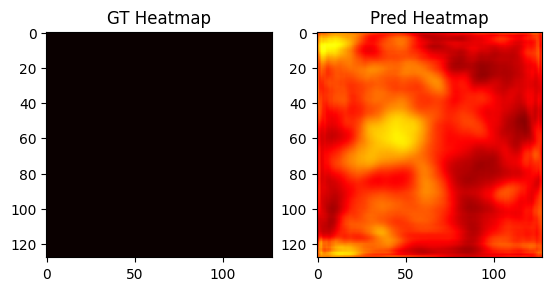


Epoch 1 completed in 275.87 seconds.
Train loss : 95.8323
Train mask loss : 89.9901
Train regr loss : 5.8422


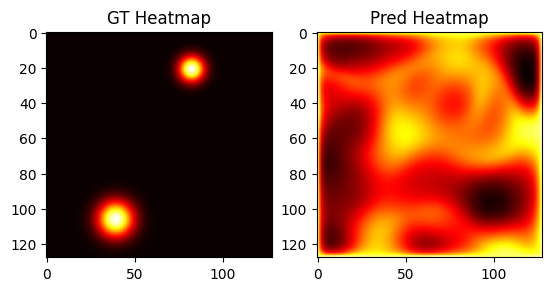


Validation loss      : 435.3238
Validation mask loss : 434.8712
Validation regr loss : 0.4525
Precision:        0.0164
Recall:           0.0722
Instance Recall:  0.0722
F1 Score:         0.0267
Normal Region FP: 10735
Current Learning Rate: 5e-05
F1 Score improved from -inf to 0.0267

Epoch 2/150

Epoch 2 completed in 276.37 seconds.
Train loss : 17.0120
Train mask loss : 15.4932
Train regr loss : 1.5189

Validation loss      : 37.0436
Validation mask loss : 36.9370
Validation regr loss : 0.1067
Precision:        0.0000
Recall:           0.0000
Instance Recall:  0.0000
F1 Score:         0.0000
Normal Region FP: 36
Current Learning Rate: 5e-05
No improvement in F1 Score for 1 epoch(s)

Epoch 3/150


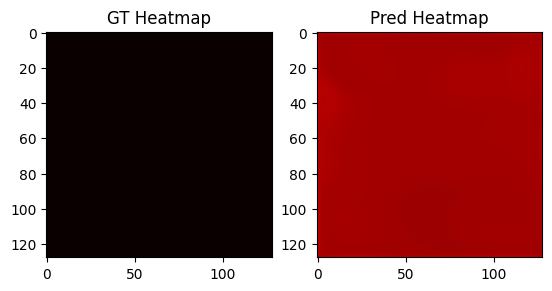


Epoch 3 completed in 275.76 seconds.
Train loss : 3.9340
Train mask loss : 3.3415
Train regr loss : 0.5926


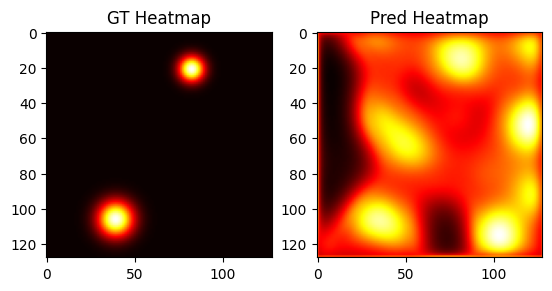


Validation loss      : 9.1624
Validation mask loss : 9.0442
Validation regr loss : 0.1182
Precision:        0.0000
Recall:           0.0000
Instance Recall:  0.0000
F1 Score:         0.0000
Normal Region FP: 0
Current Learning Rate: 5e-05
No improvement in F1 Score for 2 epoch(s)

Epoch 4/150

Epoch 4 completed in 272.64 seconds.
Train loss : 1.9982
Train mask loss : 1.6074
Train regr loss : 0.3908

Validation loss      : 5.9346
Validation mask loss : 5.8363
Validation regr loss : 0.0983
Precision:        0.0000
Recall:           0.0000
Instance Recall:  0.0000
F1 Score:         0.0000
Normal Region FP: 60
Current Learning Rate: 5e-05
No improvement in F1 Score for 3 epoch(s)

Epoch 5/150


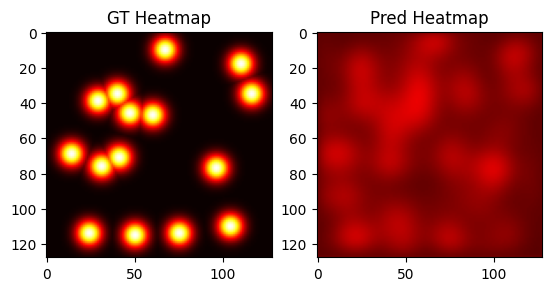


Epoch 5 completed in 269.05 seconds.
Train loss : 1.5251
Train mask loss : 1.2156
Train regr loss : 0.3095


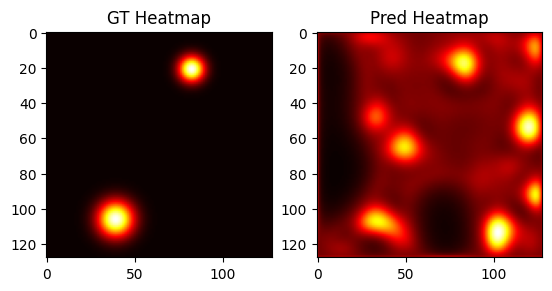


Validation loss      : 3.4682
Validation mask loss : 3.3680
Validation regr loss : 0.1001
Precision:        0.0107
Recall:           0.0051
Instance Recall:  0.0051
F1 Score:         0.0069
Normal Region FP: 85
Current Learning Rate: 5e-05
No improvement in F1 Score for 4 epoch(s)

Epoch 6/150

Epoch 6 completed in 268.36 seconds.
Train loss : 1.2746
Train mask loss : 1.0052
Train regr loss : 0.2695

Validation loss      : 6.4375
Validation mask loss : 6.3472
Validation regr loss : 0.0903
Precision:        0.0150
Recall:           0.0090
Instance Recall:  0.0090
F1 Score:         0.0113
Normal Region FP: 214
Current Learning Rate: 5e-05
No improvement in F1 Score for 5 epoch(s)

Epoch 7/150


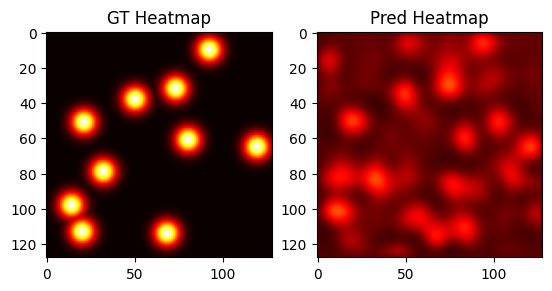


Epoch 7 completed in 269.01 seconds.
Train loss : 1.1429
Train mask loss : 0.8966
Train regr loss : 0.2463


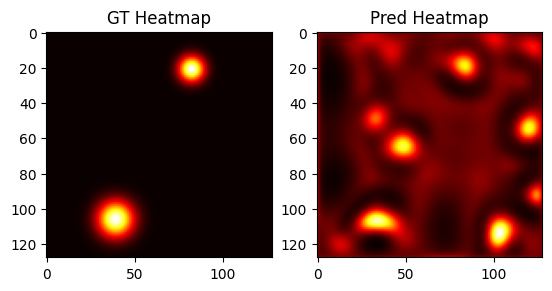


Validation loss      : 2.3994
Validation mask loss : 2.3068
Validation regr loss : 0.0926
Precision:        0.2967
Recall:           0.1663
Instance Recall:  0.1663
F1 Score:         0.2131
Normal Region FP: 107
Current Learning Rate: 5e-05
F1 Score improved from 0.0267 to 0.2131

Epoch 8/150

Epoch 8 completed in 273.29 seconds.
Train loss : 1.0956
Train mask loss : 0.8688
Train regr loss : 0.2268

Validation loss      : 4.0412
Validation mask loss : 3.9270
Validation regr loss : 0.1142
Precision:        0.2304
Recall:           0.1775
Instance Recall:  0.1775
F1 Score:         0.2005
Normal Region FP: 185
Current Learning Rate: 5e-05
No improvement in F1 Score for 1 epoch(s)

Epoch 9/150


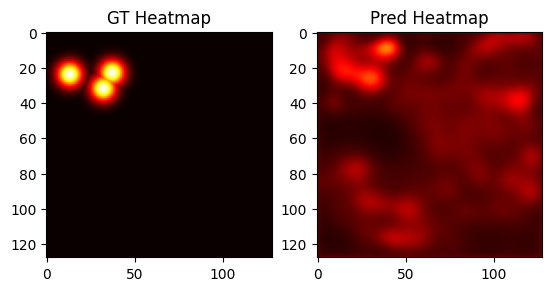


Epoch 9 completed in 269.36 seconds.
Train loss : 1.0326
Train mask loss : 0.8189
Train regr loss : 0.2137


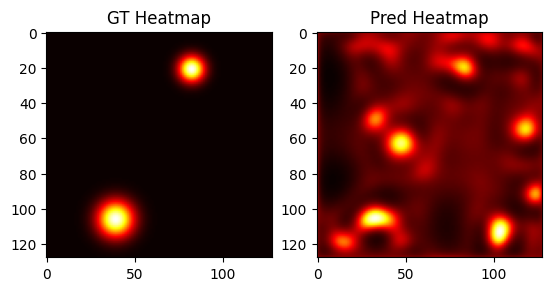


Validation loss      : 2.2697
Validation mask loss : 2.1767
Validation regr loss : 0.0930
Precision:        0.4754
Recall:           0.3586
Instance Recall:  0.3586
F1 Score:         0.4088
Normal Region FP: 101
Current Learning Rate: 5e-05
F1 Score improved from 0.2131 to 0.4088

Epoch 10/150

Epoch 10 completed in 273.16 seconds.
Train loss : 0.9304
Train mask loss : 0.7303
Train regr loss : 0.2001

Validation loss      : 2.8306
Validation mask loss : 2.7450
Validation regr loss : 0.0856
Precision:        0.4013
Recall:           0.4159
Instance Recall:  0.4159
F1 Score:         0.4085
Normal Region FP: 166
Current Learning Rate: 5e-05
No improvement in F1 Score for 1 epoch(s)

Epoch 11/150


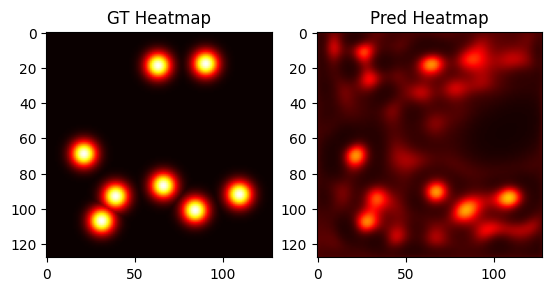


Epoch 11 completed in 269.88 seconds.
Train loss : 0.8951
Train mask loss : 0.7018
Train regr loss : 0.1934


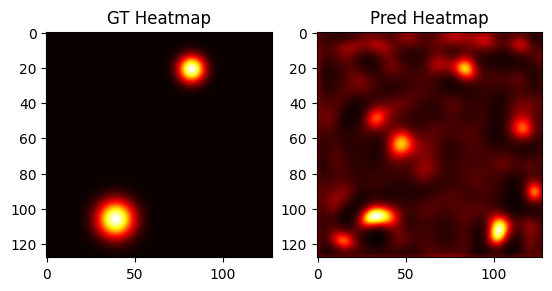


Validation loss      : 0.8146
Validation mask loss : 0.7303
Validation regr loss : 0.0843
Precision:        0.4177
Recall:           0.2911
Instance Recall:  0.2911
F1 Score:         0.3431
Normal Region FP: 8
Current Learning Rate: 5e-05
No improvement in F1 Score for 2 epoch(s)

Epoch 12/150

Epoch 12 completed in 269.06 seconds.
Train loss : 0.8640
Train mask loss : 0.6765
Train regr loss : 0.1875

Validation loss      : 1.3091
Validation mask loss : 1.2294
Validation regr loss : 0.0797
Precision:        0.4317
Recall:           0.3730
Instance Recall:  0.3730
F1 Score:         0.4002
Normal Region FP: 52
Current Learning Rate: 5e-05
No improvement in F1 Score for 3 epoch(s)

Epoch 13/150


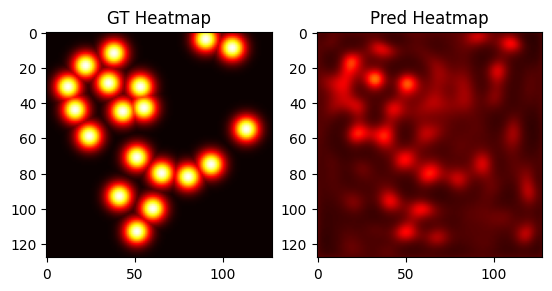


Epoch 13 completed in 269.39 seconds.
Train loss : 0.8302
Train mask loss : 0.6553
Train regr loss : 0.1749


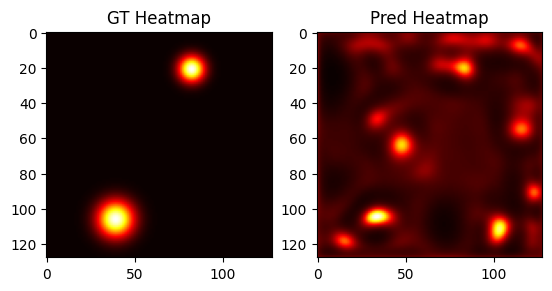


Validation loss      : 1.0817
Validation mask loss : 1.0008
Validation regr loss : 0.0810
Precision:        0.5008
Recall:           0.4574
Instance Recall:  0.4574
F1 Score:         0.4781
Normal Region FP: 35
Current Learning Rate: 5e-05
F1 Score improved from 0.4088 to 0.4781

Epoch 14/150

Epoch 14 completed in 273.94 seconds.
Train loss : 0.7704
Train mask loss : 0.5986
Train regr loss : 0.1717

Validation loss      : 1.0635
Validation mask loss : 0.9785
Validation regr loss : 0.0850
Precision:        0.5693
Recall:           0.4044
Instance Recall:  0.4044
F1 Score:         0.4729
Normal Region FP: 34
Current Learning Rate: 5e-05
No improvement in F1 Score for 1 epoch(s)

Epoch 15/150


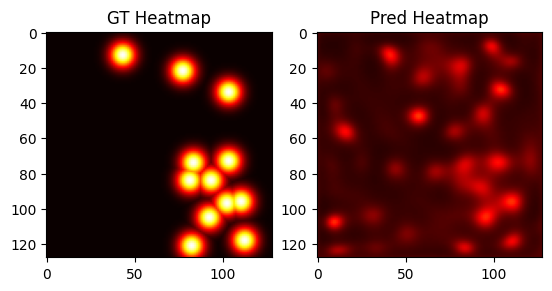


Epoch 15 completed in 269.58 seconds.
Train loss : 0.7577
Train mask loss : 0.5938
Train regr loss : 0.1640


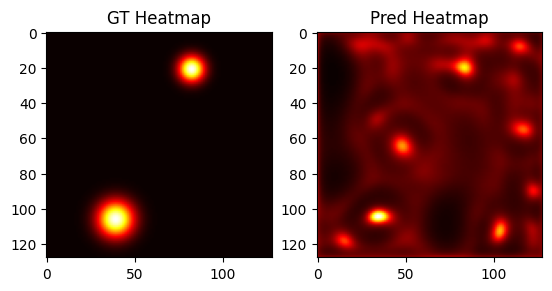


Validation loss      : 0.8620
Validation mask loss : 0.7772
Validation regr loss : 0.0848
Precision:        0.5314
Recall:           0.3788
Instance Recall:  0.3788
F1 Score:         0.4423
Normal Region FP: 18
Current Learning Rate: 5e-05
No improvement in F1 Score for 2 epoch(s)

Epoch 16/150

Epoch 16 completed in 268.90 seconds.
Train loss : 0.7320
Train mask loss : 0.5717
Train regr loss : 0.1603

Validation loss      : 0.7110
Validation mask loss : 0.6321
Validation regr loss : 0.0790
Precision:        0.5658
Recall:           0.4935
Instance Recall:  0.4935
F1 Score:         0.5272
Normal Region FP: 8
Current Learning Rate: 5e-05
F1 Score improved from 0.4781 to 0.5272

Epoch 17/150


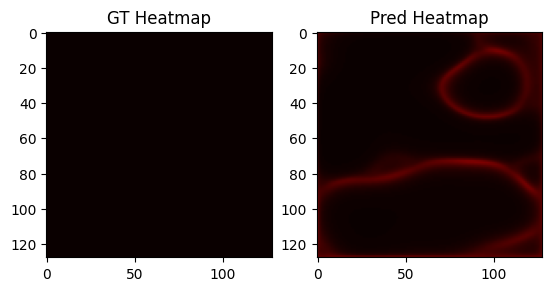


Epoch 17 completed in 274.11 seconds.
Train loss : 0.7063
Train mask loss : 0.5523
Train regr loss : 0.1539


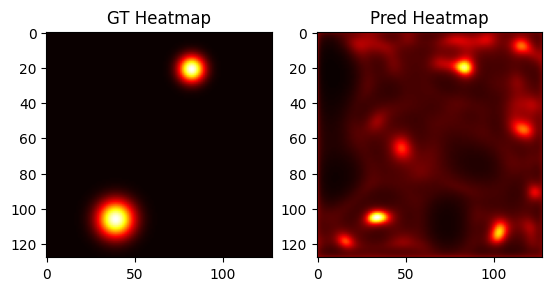


Validation loss      : 1.1026
Validation mask loss : 1.0274
Validation regr loss : 0.0752
Precision:        0.5977
Recall:           0.5375
Instance Recall:  0.5375
F1 Score:         0.5660
Normal Region FP: 56
Current Learning Rate: 5e-05
F1 Score improved from 0.5272 to 0.5660

Epoch 18/150

Epoch 18 completed in 273.58 seconds.
Train loss : 0.6715
Train mask loss : 0.5228
Train regr loss : 0.1487

Validation loss      : 0.8255
Validation mask loss : 0.7433
Validation regr loss : 0.0821
Precision:        0.5905
Recall:           0.5404
Instance Recall:  0.5404
F1 Score:         0.5643
Normal Region FP: 22
Current Learning Rate: 5e-05
No improvement in F1 Score for 1 epoch(s)

Epoch 19/150


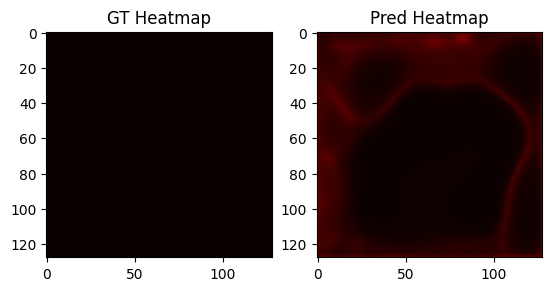


Epoch 19 completed in 269.23 seconds.
Train loss : 0.6515
Train mask loss : 0.5039
Train regr loss : 0.1476


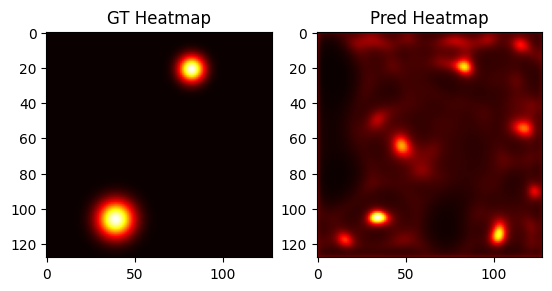


Validation loss      : 1.0788
Validation mask loss : 0.9997
Validation regr loss : 0.0792
Precision:        0.5470
Recall:           0.5877
Instance Recall:  0.5877
F1 Score:         0.5666
Normal Region FP: 43
Current Learning Rate: 5e-05
F1 Score improved from 0.5660 to 0.5666

Epoch 20/150

Epoch 20 completed in 273.66 seconds.
Train loss : 0.6476
Train mask loss : 0.5038
Train regr loss : 0.1438

Validation loss      : 1.4461
Validation mask loss : 1.3644
Validation regr loss : 0.0816
Precision:        0.5572
Recall:           0.5848
Instance Recall:  0.5848
F1 Score:         0.5707
Normal Region FP: 83
Current Learning Rate: 5e-05
F1 Score improved from 0.5666 to 0.5707

Epoch 21/150


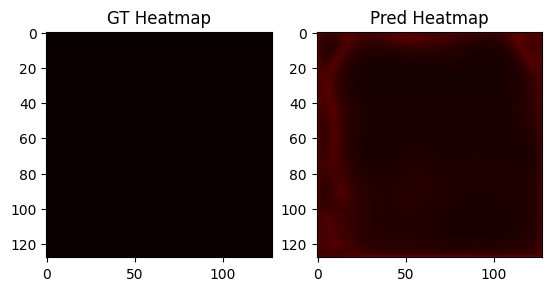


Epoch 21 completed in 274.36 seconds.
Train loss : 0.6078
Train mask loss : 0.4670
Train regr loss : 0.1408


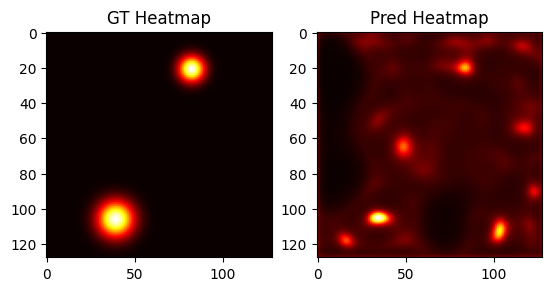


Validation loss      : 1.1451
Validation mask loss : 1.0741
Validation regr loss : 0.0710
Precision:        0.5538
Recall:           0.6108
Instance Recall:  0.6108
F1 Score:         0.5809
Normal Region FP: 62
Current Learning Rate: 5e-05
F1 Score improved from 0.5707 to 0.5809

Epoch 22/150

Epoch 22 completed in 273.20 seconds.
Train loss : 0.6076
Train mask loss : 0.4682
Train regr loss : 0.1394

Validation loss      : 0.8837
Validation mask loss : 0.8088
Validation regr loss : 0.0749
Precision:        0.5979
Recall:           0.5375
Instance Recall:  0.5375
F1 Score:         0.5661
Normal Region FP: 29
Current Learning Rate: 5e-06
No improvement in F1 Score for 1 epoch(s)

Epoch 23/150


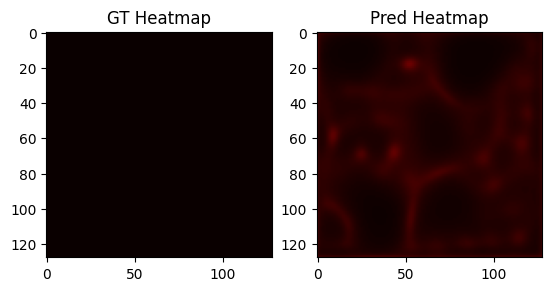


Epoch 23 completed in 269.25 seconds.
Train loss : 0.5459
Train mask loss : 0.4131
Train regr loss : 0.1328


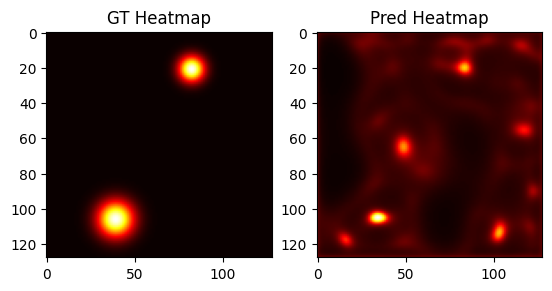


Validation loss      : 1.0586
Validation mask loss : 0.9875
Validation regr loss : 0.0711
Precision:        0.5763
Recall:           0.6100
Instance Recall:  0.6100
F1 Score:         0.5927
Normal Region FP: 52
Current Learning Rate: 5e-06
F1 Score improved from 0.5809 to 0.5927

Epoch 24/150

Epoch 24 completed in 273.68 seconds.
Train loss : 0.5352
Train mask loss : 0.4040
Train regr loss : 0.1312

Validation loss      : 0.8487
Validation mask loss : 0.7710
Validation regr loss : 0.0777
Precision:        0.6032
Recall:           0.5938
Instance Recall:  0.5938
F1 Score:         0.5984
Normal Region FP: 16
Current Learning Rate: 5e-06
F1 Score improved from 0.5927 to 0.5984

Epoch 25/150


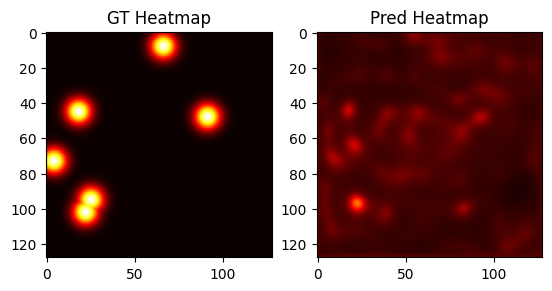


Epoch 25 completed in 273.31 seconds.
Train loss : 0.5343
Train mask loss : 0.4023
Train regr loss : 0.1319


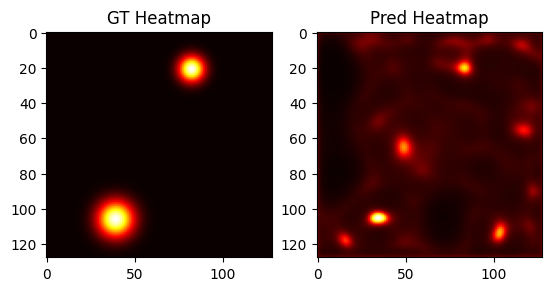


Validation loss      : 0.9419
Validation mask loss : 0.8673
Validation regr loss : 0.0746
Precision:        0.5778
Recall:           0.6147
Instance Recall:  0.6147
F1 Score:         0.5957
Normal Region FP: 25
Current Learning Rate: 5e-06
No improvement in F1 Score for 1 epoch(s)

Epoch 26/150

Epoch 26 completed in 269.02 seconds.
Train loss : 0.5244
Train mask loss : 0.3942
Train regr loss : 0.1303

Validation loss      : 0.8543
Validation mask loss : 0.7822
Validation regr loss : 0.0721
Precision:        0.6053
Recall:           0.5898
Instance Recall:  0.5898
F1 Score:         0.5975
Normal Region FP: 24
Current Learning Rate: 5e-06
No improvement in F1 Score for 2 epoch(s)

Epoch 27/150


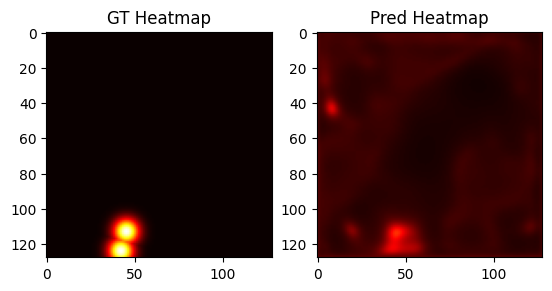


Epoch 27 completed in 269.30 seconds.
Train loss : 0.5180
Train mask loss : 0.3874
Train regr loss : 0.1307


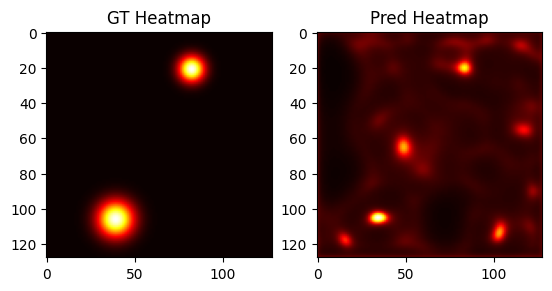


Validation loss      : 1.0614
Validation mask loss : 0.9903
Validation regr loss : 0.0711
Precision:        0.5685
Recall:           0.6104
Instance Recall:  0.6104
F1 Score:         0.5887
Normal Region FP: 47
Current Learning Rate: 5e-06
No improvement in F1 Score for 3 epoch(s)

Epoch 28/150

Epoch 28 completed in 269.48 seconds.
Train loss : 0.5160
Train mask loss : 0.3869
Train regr loss : 0.1292

Validation loss      : 0.9444
Validation mask loss : 0.8727
Validation regr loss : 0.0717
Precision:        0.5756
Recall:           0.6100
Instance Recall:  0.6100
F1 Score:         0.5923
Normal Region FP: 35
Current Learning Rate: 5.000000000000001e-07
No improvement in F1 Score for 4 epoch(s)

Epoch 29/150


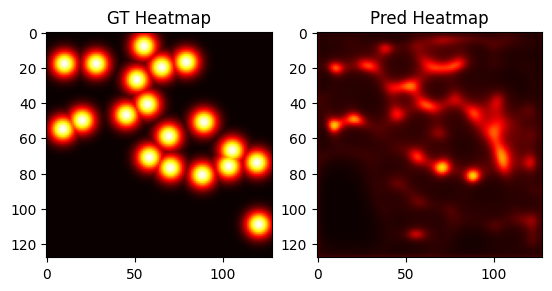


Epoch 29 completed in 269.36 seconds.
Train loss : 0.5143
Train mask loss : 0.3856
Train regr loss : 0.1287


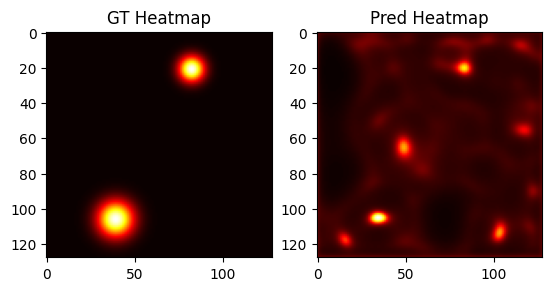


Validation loss      : 0.8847
Validation mask loss : 0.8115
Validation regr loss : 0.0732
Precision:        0.5814
Recall:           0.6118
Instance Recall:  0.6118
F1 Score:         0.5962
Normal Region FP: 24
Current Learning Rate: 5.000000000000001e-07
No improvement in F1 Score for 5 epoch(s)

Epoch 30/150

Epoch 30 completed in 269.59 seconds.
Train loss : 0.5263
Train mask loss : 0.3983
Train regr loss : 0.1280

Validation loss      : 0.9184
Validation mask loss : 0.8446
Validation regr loss : 0.0738
Precision:        0.5841
Recall:           0.6053
Instance Recall:  0.6053
F1 Score:         0.5945
Normal Region FP: 30
Current Learning Rate: 5.000000000000001e-07
No improvement in F1 Score for 6 epoch(s)

Epoch 31/150


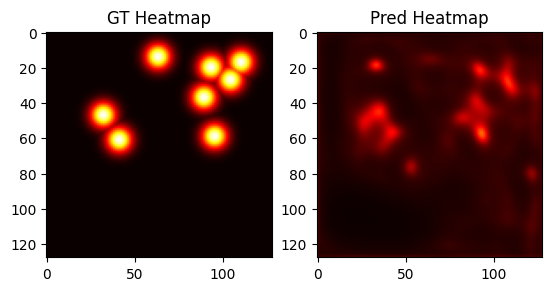


Epoch 31 completed in 270.11 seconds.
Train loss : 0.5095
Train mask loss : 0.3821
Train regr loss : 0.1274


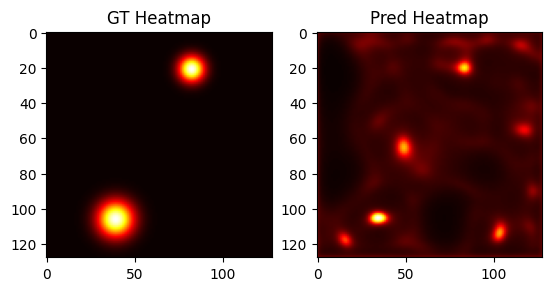


Validation loss      : 0.9543
Validation mask loss : 0.8784
Validation regr loss : 0.0759
Precision:        0.5809
Recall:           0.6046
Instance Recall:  0.6046
F1 Score:         0.5925
Normal Region FP: 30
Current Learning Rate: 5.000000000000001e-07
No improvement in F1 Score for 7 epoch(s)

Epoch 32/150

Epoch 32 completed in 270.82 seconds.
Train loss : 0.5148
Train mask loss : 0.3857
Train regr loss : 0.1291

Validation loss      : 0.9209
Validation mask loss : 0.8492
Validation regr loss : 0.0717
Precision:        0.5863
Recall:           0.6032
Instance Recall:  0.6032
F1 Score:         0.5946
Normal Region FP: 29
Current Learning Rate: 5.000000000000001e-07
No improvement in F1 Score for 8 epoch(s)

Epoch 33/150


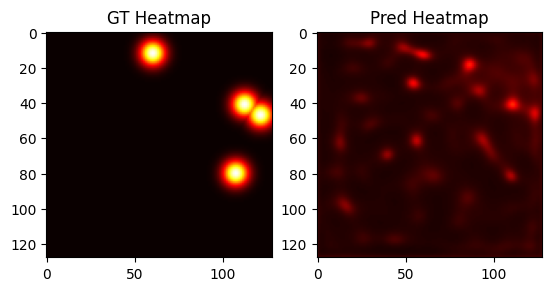


Epoch 33 completed in 270.64 seconds.
Train loss : 0.5030
Train mask loss : 0.3763
Train regr loss : 0.1267


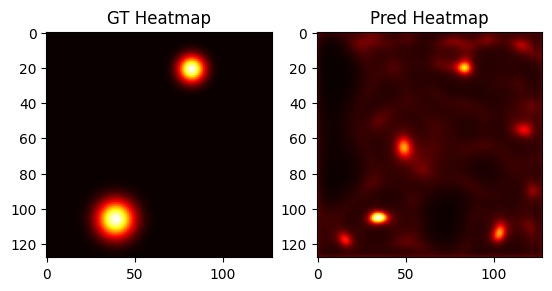


Validation loss      : 0.9362
Validation mask loss : 0.8624
Validation regr loss : 0.0738
Precision:        0.5867
Recall:           0.6068
Instance Recall:  0.6068
F1 Score:         0.5966
Normal Region FP: 29
Current Learning Rate: 5.000000000000001e-07
No improvement in F1 Score for 9 epoch(s)

Epoch 34/150

Epoch 34 completed in 270.14 seconds.
Train loss : 0.5062
Train mask loss : 0.3777
Train regr loss : 0.1285

Validation loss      : 0.9337
Validation mask loss : 0.8622
Validation regr loss : 0.0715
Precision:        0.5720
Recall:           0.6079
Instance Recall:  0.6079
F1 Score:         0.5894
Normal Region FP: 36
Current Learning Rate: 1e-07
No improvement in F1 Score for 10 epoch(s)

Epoch 35/150


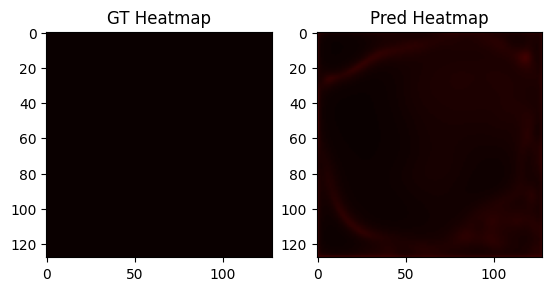


Epoch 35 completed in 270.97 seconds.
Train loss : 0.5084
Train mask loss : 0.3800
Train regr loss : 0.1285


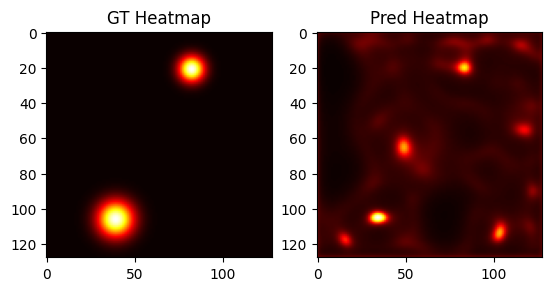


Validation loss      : 0.9378
Validation mask loss : 0.8651
Validation regr loss : 0.0728
Precision:        0.5818
Recall:           0.6057
Instance Recall:  0.6057
F1 Score:         0.5935
Normal Region FP: 29
Current Learning Rate: 1e-07
No improvement in F1 Score for 11 epoch(s)

Epoch 36/150

Epoch 36 completed in 270.21 seconds.
Train loss : 0.5143
Train mask loss : 0.3862
Train regr loss : 0.1281

Validation loss      : 0.9538
Validation mask loss : 0.8817
Validation regr loss : 0.0721
Precision:        0.5824
Recall:           0.6053
Instance Recall:  0.6053
F1 Score:         0.5937
Normal Region FP: 32
Current Learning Rate: 1e-07
No improvement in F1 Score for 12 epoch(s)

Epoch 37/150


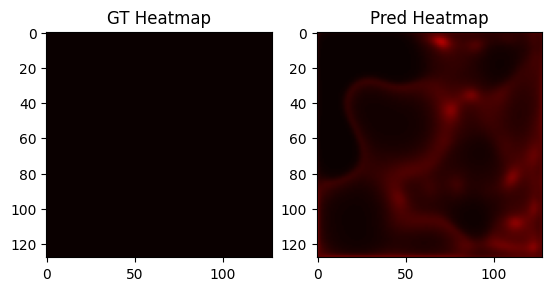


Epoch 37 completed in 270.11 seconds.
Train loss : 0.5138
Train mask loss : 0.3850
Train regr loss : 0.1289


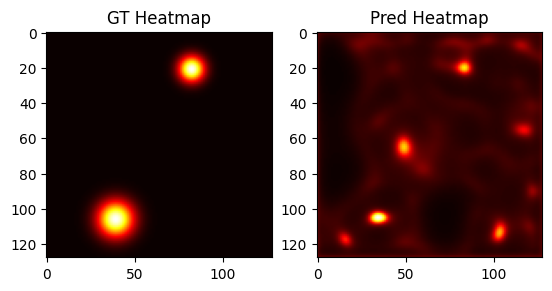


Validation loss      : 1.0624
Validation mask loss : 0.9919
Validation regr loss : 0.0705
Precision:        0.5642
Recall:           0.6291
Instance Recall:  0.6291
F1 Score:         0.5949
Normal Region FP: 42
Current Learning Rate: 1e-07
No improvement in F1 Score for 13 epoch(s)

Epoch 38/150

Epoch 38 completed in 269.73 seconds.
Train loss : 0.5063
Train mask loss : 0.3781
Train regr loss : 0.1282

Validation loss      : 0.9282
Validation mask loss : 0.8559
Validation regr loss : 0.0723
Precision:        0.5818
Recall:           0.6028
Instance Recall:  0.6028
F1 Score:         0.5921
Normal Region FP: 31
Current Learning Rate: 1e-07
No improvement in F1 Score for 14 epoch(s)

Epoch 39/150


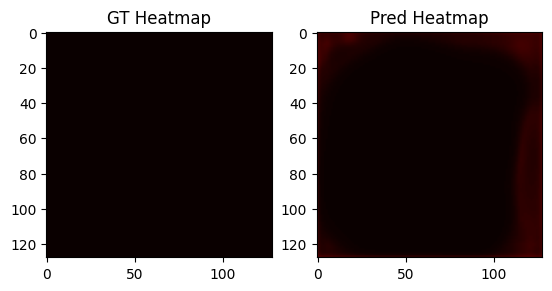


Epoch 39 completed in 270.06 seconds.
Train loss : 0.5024
Train mask loss : 0.3757
Train regr loss : 0.1266


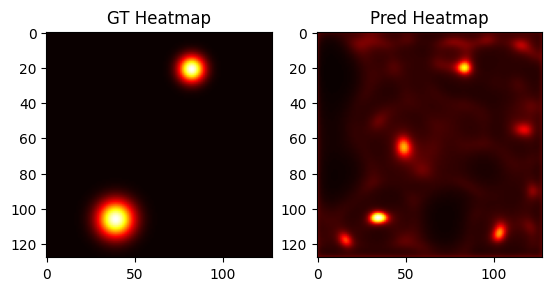


Validation loss      : 0.9505
Validation mask loss : 0.8723
Validation regr loss : 0.0782
Precision:        0.5706
Recall:           0.6064
Instance Recall:  0.6064
F1 Score:         0.5880
Normal Region FP: 26
Current Learning Rate: 1e-07
No improvement in F1 Score for 15 epoch(s)
Early stopping triggered after 15 epochs without improvement.


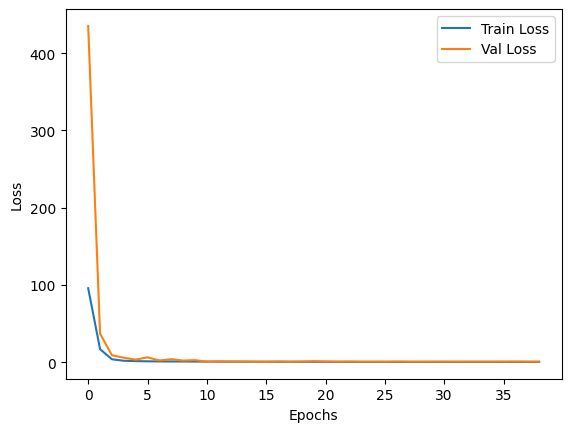

In [62]:
# Get current timestamp (format: YYYYMMDD_HHMMSS)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create save directory with timestamp
save_dir = f'/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/student/adamw18_checkpoints_{timestamp}'
os.makedirs(save_dir, exist_ok=True)

# Initialize tracking variables
epochs = 150
best_loss = float('inf')
best_f1 = float('-inf')
epochs_no_improve = 0
early_stop_patience = 15
early_stop_flag = False
train_loss_all = []
val_loss_all = []
metrics_log = []

for epoch in range(epochs):
    early_stop_flag, best_loss, best_f1, epochs_no_improve, train_loss, val_loss, F1_score = train_student(
        epoch, teacher_model, student_model, save_dir, best_loss, best_f1, epochs_no_improve, early_stop_patience)
    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)

    metrics_log.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'F1_score': F1_score
    })

    if early_stop_flag:
        # Save CSV of metrics
        metrics_df = pd.DataFrame(metrics_log)
        csv_path = os.path.join(save_dir, 'training_metrics.csv')
        metrics_df.to_csv(csv_path, index=False)

        # Plot training and validation loss
        plt.plot(train_loss_all, label='Train Loss')
        plt.plot(val_loss_all, label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        break

# If training completes without early stopping
else:
    metrics_df = pd.DataFrame(metrics_log)
    csv_path = os.path.join(save_dir, 'training_metrics.csv')
    metrics_df.to_csv(csv_path, index=False)

## 4. Evaluation

#### Best model

In [63]:
model = centernet(model_name='resnet18')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model_path = "/content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/student/adamw18_checkpoints_20250629_155227/best_model.pth"
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [64]:
save_dir = model_path.split('best_model.pth')[0]
metrics, froc, recall_list, csv_path = test(model, test_loader, device, save_dir)
print(f"Saved results to: {csv_path}")

Precision: 0.4808
Recall:    0.5268
Instance Recall: 0.5268
F1 Score:  0.5027
FPs:       74.0000
FROC Score: 0.1414
Saved results to: /content/drive/MyDrive/Dissertation_Chatwipa/model_checkpoint/student/adamw18_checkpoints_20250629_155227/test_results.csv
